## Unsupervised Learning Trading Strategy
- Download/Load SP500 stocks prices data.
- Calculate different features and indicators on each stock.
- Aggregate on monthly level and filter top 150 most liquid stocks.
- Calculate Monthly Returns for different time-horizons.
- Download Fama-French Factors and Calculate Rolling Factor Betas.
- For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
- For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
- Visualize Portfolio returns and compare to SP500 returns.
### All Packages Needed:
- pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt
## 1. Download/Load SP500 stocks prices data.

In [2]:
!pip install statsmodels
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install pandas-datareader
!pip install yfinance
!pip install datetime
!pip install scikit-learn
!pip install PyPortfolioOpt
!pip install pandas-ta

In [3]:
# Reinstalar pandas-ta con una versión específica compatible con numpy
!pip uninstall -y pandas-ta
!pip install pandas-ta==0.3.14b0

Found existing installation: pandas_ta 0.3.14b0
Uninstalling pandas_ta-0.3.14b0:
  Successfully uninstalled pandas_ta-0.3.14b0
  Using cached pandas_ta-0.3.14b0-py3-none-any.whl
  Using cached pandas_ta-0.3.14b0-py3-none-any.whl


In [4]:
# Corregir el error de importación en pandas-ta
import os
import site

# Buscar el archivo directamente en site-packages
site_packages = site.getsitepackages()[0]
squeeze_pro_path = os.path.join(site_packages, 'pandas_ta', 'momentum', 'squeeze_pro.py')

# Verificar si el archivo existe
if os.path.exists(squeeze_pro_path):
    print(f"Archivo encontrado en: {squeeze_pro_path}")
    
    # Leer el contenido actual
    with open(squeeze_pro_path, 'r') as file:
        content = file.read()
    
    # Reemplazar 'from numpy import NaN as npNaN' por 'from numpy import nan as npNaN'
    if 'from numpy import NaN as npNaN' in content:
        content = content.replace('from numpy import NaN as npNaN', 'from numpy import nan as npNaN')
        
        # Guardar el archivo modificado
        with open(squeeze_pro_path, 'w') as file:
            file.write(content)
        print("El archivo ha sido corregido correctamente.")
    else:
        print("El archivo ya ha sido corregido o tiene un formato diferente.")
else:
    print(f"Buscando archivo en: {site_packages}")
    
    # Buscar el archivo en todo el site-packages
    found = False
    for root, dirs, files in os.walk(site_packages):
        if 'squeeze_pro.py' in files:
            found_path = os.path.join(root, 'squeeze_pro.py')
            print(f"Archivo encontrado en ubicación alternativa: {found_path}")
            
            # Leer el contenido
            with open(found_path, 'r') as file:
                content = file.read()
            
            if 'from numpy import NaN as npNaN' in content:
                content = content.replace('from numpy import NaN as npNaN', 'from numpy import nan as npNaN')
                
                # Guardar el archivo modificado
                with open(found_path, 'w') as file:
                    file.write(content)
                print("El archivo ha sido corregido correctamente.")
                found = True
                break
            else:
                print("El archivo ya ha sido corregido o tiene un formato diferente.")
                found = True
                break
    
    if not found:
        print("No se pudo encontrar el archivo 'squeeze_pro.py' en ninguna ubicación.")


Buscando archivo en: c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv
Archivo encontrado en ubicación alternativa: c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\pandas_ta\momentum\squeeze_pro.py
El archivo ha sido corregido correctamente.
Archivo encontrado en ubicación alternativa: c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\pandas_ta\momentum\squeeze_pro.py
El archivo ha sido corregido correctamente.


In [5]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

print(f"Número de símbolos: {len(symbols_list)}")
print(f"Primeros 10 símbolos: {symbols_list[:10]}")

end_date = '2025-05-14'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

print(f"\nDescargando datos desde {start_date} hasta {end_date}")

# Descargar los datos con parámetros específicos para preservar todas las columnas
df_raw = yf.download(tickers=symbols_list,
                     start=start_date,
                     end=end_date,
                     auto_adjust=False,  # Importante: no ajustar automáticamente
                     prepost=True,
                     threads=True)

print(f"\nForma de df_raw: {df_raw.shape}")
print(f"Columnas de df_raw: {df_raw.columns.tolist()}")

# Verificar si tenemos datos
if df_raw.empty:
    print("¡ERROR: No se pudieron descargar datos!")
else:
    # Reorganizar el DataFrame correctamente
    df = df_raw.stack(level=1)  # Stack el nivel de los tickers
    df.index.names = ['date', 'ticker']
    
    # Convertir nombres de columnas a minúsculas
    df.columns = df.columns.str.lower()
    
    print(f"\nForma de df después de stack: {df.shape}")
    print(f"Columnas de df: {df.columns.tolist()}")
    print(f"Nombres del índice: {df.index.names}")
    
    # Verificar que tenemos adj close
    if 'adj close' in df.columns:
        print("\n✓ Columna 'adj close' encontrada correctamente")
        print(f"Primeros valores de 'adj close':")
        print(df['adj close'].dropna().head())
    else:
        print("\n✗ Columna 'adj close' NO encontrada")
        print("Columnas disponibles:", df.columns.tolist())

df


Número de símbolos: 503
Primeros 10 símbolos: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']

Descargando datos desde 2017-05-16 00:00:00 hasta 2025-05-14


[*********************100%***********************]  503 of 503 completed




Forma de df_raw: (2010, 3018)
Columnas de df_raw: [('Adj Close', 'A'), ('Adj Close', 'AAPL'), ('Adj Close', 'ABBV'), ('Adj Close', 'ABNB'), ('Adj Close', 'ABT'), ('Adj Close', 'ACGL'), ('Adj Close', 'ACN'), ('Adj Close', 'ADBE'), ('Adj Close', 'ADI'), ('Adj Close', 'ADM'), ('Adj Close', 'ADP'), ('Adj Close', 'ADSK'), ('Adj Close', 'AEE'), ('Adj Close', 'AEP'), ('Adj Close', 'AES'), ('Adj Close', 'AFL'), ('Adj Close', 'AIG'), ('Adj Close', 'AIZ'), ('Adj Close', 'AJG'), ('Adj Close', 'AKAM'), ('Adj Close', 'ALB'), ('Adj Close', 'ALGN'), ('Adj Close', 'ALL'), ('Adj Close', 'ALLE'), ('Adj Close', 'AMAT'), ('Adj Close', 'AMCR'), ('Adj Close', 'AMD'), ('Adj Close', 'AME'), ('Adj Close', 'AMGN'), ('Adj Close', 'AMP'), ('Adj Close', 'AMT'), ('Adj Close', 'AMZN'), ('Adj Close', 'ANET'), ('Adj Close', 'ANSS'), ('Adj Close', 'AON'), ('Adj Close', 'AOS'), ('Adj Close', 'APA'), ('Adj Close', 'APD'), ('Adj Close', 'APH'), ('Adj Close', 'APO'), ('Adj Close', 'APTV'), ('Adj Close', 'ARE'), ('Adj Clos

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-05-16 A        53.492157   56.830002   58.380001   56.450001   58.380001   
           AAPL     36.213566   38.867500   39.014999   38.680000   38.985001   
           ABBV     47.478661   66.849998   66.919998   66.330002   66.730003   
           ABT      37.904324   43.689999   44.590000   43.410000   44.590000   
           ACGL     30.206877   31.766666   31.863333   31.590000   31.790001   
...                       ...         ...         ...         ...         ...   
2025-05-13 XYL     126.525925  126.930000  127.709999  126.779999  127.180000   
           YUM     145.008682  145.720001  147.009995  144.809998  147.000000   
           ZBH      97.489998   97.489998   98.230003   96.360001   97.989998   
           ZBRA    302.380005  302.380005  305.290009  300.369995  300.750000   
           ZTS     160.410004  160.410004  162.910004  160.059998  160.720001   

Price                  volume  
date       ticker              
2017-05-16 A        1032600.0  
           AAPL    80194000.0  
           ABBV     6313500.0  
           ABT      7159300.0  
           ACGL      804600.0  
...                       ...  
2025-05-13 XYL      1327600.0  
           YUM      1880000.0  
           ZBH      2324000.0  
           ZBRA      846800.0  
           ZTS      3336700.0  

[990380 rows x 6 columns]

# 2. Calculate features and technical indicators for each stock.
- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volume

 \begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}
    

In [6]:
# Calcular Garman-Klass Volatility
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

# Calcular RSI
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

# Calcular Bollinger Bands
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

# Calcular ATR normalizado
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['adj close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

# Calcular MACD normalizado
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

# Calcular volumen en millones de dólares
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

# Mostrar el DataFrame con los indicadores calculados
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-05-16 A        53.492157   56.830002   58.380001   56.450001   58.380001   
           AAPL     36.213566   38.867500   39.014999   38.680000   38.985001   
           ABBV     47.478661   66.849998   66.919998   66.330002   66.730003   
           ABT      37.904324   43.689999   44.590000   43.410000   44.590000   
           ACGL     30.206877   31.766666   31.863333   31.590000   31.790001   
...                       ...         ...         ...         ...         ...   
2025-05-13 XYL     126.525925  126.930000  127.709999  126.779999  127.180000   
           YUM     145.008682  145.720001  147.009995  144.809998  147.000000   
           ZBH      97.489998   97.489998   98.230003   96.360001   97.989998   
           ZBRA    302.380005  302.380005  305.290009  300.369995  300.750000   
           ZTS     160.410004  160.410004  162.910004  160.059998  160.720001   

Price                  volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-05-16 A        1032600.0         -0.002388        NaN       NaN   
           AAPL    80194000.0         -0.002064        NaN       NaN   
           ABBV     6313500.0         -0.044715        NaN       NaN   
           ABT      7159300.0         -0.009834        NaN       NaN   
           ACGL      804600.0         -0.000971        NaN       NaN   
...                       ...               ...        ...       ...   
2025-05-13 XYL      1327600.0          0.000016  61.794903  4.675161   
           YUM      1880000.0          0.000042  45.965012  4.957244   
           ZBH      2324000.0          0.000175  44.094881  4.524274   
           ZBRA      846800.0          0.000121  63.240049  5.357481   
           ZTS      3336700.0          0.000154  53.479526  4.982374   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2017-05-16 A            NaN       NaN       NaN       NaN      55.236001  
           AAPL         NaN       NaN       NaN       NaN    2904.110698  
           ABBV         NaN       NaN       NaN       NaN     299.756524  
           ABT          NaN       NaN       NaN       NaN     271.368424  
           ACGL         NaN       NaN       NaN       NaN      24.304453  
...                     ...       ...       ...       ...            ...  
2025-05-13 XYL     4.774051  4.872941 -1.426472  1.367672     167.975818  
           YUM     4.989772  5.022299 -1.865657 -0.602271     272.616323  
           ZBH     4.595950  4.667626 -1.120584 -0.988090     226.566755  
           ZBRA    5.522473  5.687466  0.929265  0.755502     256.055388  
           ZTS     5.043721  5.105067 -0.784831  0.327079     535.240059  

[990380 rows x 14 columns]

# 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.
- To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [7]:
last_cols = [c for c in df.columns.unique(0) if c not in ['open', 'high', 'low', 'close', 'volume','dollar_volume']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                    df.unstack()[last_cols].resample('M').last().stack('ticker')],
                   axis=1)).dropna()

data
#df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-06-30 A          109.548804   55.950836         -0.001012  53.174502   
           AAPL      4268.541560   33.546505         -0.002065  38.245761   
           ABBV       298.847290   51.498535         -0.045411  73.663886   
           ABT        302.877917   42.172787         -0.008142  70.961806   
           ACGL        69.558512   29.569775         -0.001103  42.661682   
...                          ...         ...               ...        ...   
2025-05-31 XYL        175.357933  126.525925          0.000016  61.794903   
           YUM        268.608580  145.008682          0.000042  45.965012   
           ZBH        321.604173   97.489998          0.000175  44.094881   
           ZBRA       206.729977  302.380005          0.000121  63.240049   
           ZTS        590.935495  160.410004          0.000154  53.479526   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2017-06-30 A       4.027342  4.046235  4.065128 -0.308421  0.007962  
           AAPL    3.511176  3.563069  3.614963 -1.023574 -0.501340  
           ABBV    3.890018  3.937576  3.985134  0.679389  0.411809  
           ABT     3.715288  3.752833  3.790378 -0.115991  0.607717  
           ACGL    3.402675  3.430145  3.457615 -0.875012 -0.450039  
...                     ...       ...       ...       ...       ...  
2025-05-31 XYL     4.675161  4.774051  4.872941 -1.426472  1.367672  
           YUM     4.957244  4.989772  5.022299 -1.865657 -0.602271  
           ZBH     4.524274  4.595950  4.667626 -1.120584 -0.988090  
           ZBRA    5.357481  5.522473  5.687466  0.929265  0.755502  
           ZTS     4.982374  5.043721  5.105067 -0.784831  0.327079  

[47298 rows x 9 columns]

- Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [8]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-05-31 AAPL     44.204178         -0.001200  59.945560  3.779782   
           ABBV     72.653069         -0.041405  46.193202  4.288175   
           ABT      54.458660         -0.006269  54.184907  3.961811   
           ACN     140.315765         -0.004265  53.108575  4.925236   
           ADBE    249.279999          0.000167  67.105803  5.431916   
...                       ...               ...        ...       ...   
2025-05-31 VZ       42.650002          0.000075  47.657027  3.762462   
           WDAY    270.019989          0.000093  66.035757  5.368577   
           WFC      75.989998          0.000205  62.935699  4.151715   
           WMT      95.879997          0.000220  54.534919  4.527725   
           XOM     108.461052          0.000068  52.842848  4.633090   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2018-05-31 AAPL    3.809634  3.839485 -0.917051  0.088349  
           ABBV    4.337686  4.387196  1.791505  0.018221  
           ABT     4.004612  4.047413  0.196903  0.207944  
           ACN     4.944963  4.964690  0.226593 -0.002850  
           ADBE    5.480050  5.528185 -1.184392  0.460818  
...                     ...       ...       ...       ...  
2025-05-31 VZ      3.791511  3.820560 -1.781915 -0.010364  
           WDAY    5.491662  5.614747  0.514480  1.479676  
           WFC     4.260194  4.368673 -0.993850  1.680193  
           WMT     4.572275  4.616824 -0.575134  2.048463  
           XOM     4.669005  4.704921 -1.357163 -0.390327  

[12665 rows x 8 columns]

# 4. Calculate Monthly Returns for different time horizons as features.
- To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [9]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2019-05-31 AAPL     42.043274         -0.000701  34.632860  3.729628   
           ABBV     58.990608         -0.028138  40.509218  4.087179   
           ABT      68.556511         -0.004000  47.744544  4.223157   
           ACN     163.241577         -0.002625  54.904820  5.066404   
           ADBE    270.899994          0.000117  47.431756  5.595761   
...                       ...               ...        ...       ...   
2025-05-31 VZ       42.650002          0.000075  47.657027  3.762462   
           WDAY    270.019989          0.000093  66.035757  5.368577   
           WFC      75.989998          0.000205  62.935699  4.151715   
           WMT      95.879997          0.000220  54.534919  4.527725   
           XOM     108.461052          0.000068  52.842848  4.633090   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2019-05-31 AAPL    3.836748  3.943868 -1.451579 -0.780296  -0.124213   
           ABBV    4.120630  4.154082  0.355169 -0.345994  -0.033758   
           ABT     4.246252  4.269347  0.499781 -0.476092  -0.043112   
           ACN     5.093782  5.121161  0.066913  0.003359  -0.025182   
           ADBE    5.627233  5.658705 -0.977400 -0.102993  -0.063440   
...                     ...       ...       ...       ...        ...   
2025-05-31 VZ      3.791511  3.820560 -1.781915 -0.010364  -0.032002   
           WDAY    5.491662  5.614747  0.514480  1.479676   0.102122   
           WFC     4.260194  4.368673 -0.993850  1.680193   0.076002   
           WMT     4.572275  4.616824 -0.575134  2.048463  -0.011704   
           XOM     4.669005  4.704921 -1.357163 -0.390327   0.036259   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2019-05-31 AAPL    -0.038120   0.004969  -0.001953  -0.027496   -0.004168  
           ABBV    -0.017923  -0.006405  -0.029679  -0.020684   -0.017210  
           ABT     -0.022126  -0.005087   0.006087   0.016011    0.019370  
           ACN      0.009963   0.036194   0.014672   0.007720    0.012691  
           ADBE     0.008240   0.010555   0.012871   0.003078    0.006955  
...                      ...        ...        ...        ...         ...  
2025-05-31 VZ      -0.022576   0.001814  -0.000893   0.007763    0.008454  
           WDAY     0.075293   0.008385   0.012929   0.002851    0.020585  
           WFC      0.031655  -0.008209   0.001339   0.031397    0.022017  
           WMT      0.046323  -0.007610   0.007236   0.025165    0.032802  
           XOM     -0.040639  -0.005631  -0.010920  -0.006372   -0.003637  

[10470 rows x 14 columns]

# 5. Download Fama-French Factors and Calculate Rolling Factor Betas.
- We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

- The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

- We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [10]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-05-31 AAPL   -0.0692 -0.0156 -0.0245 -0.0048  0.0176  -0.124213
           ABBV   -0.0692 -0.0156 -0.0245 -0.0048  0.0176  -0.033758
           ABT    -0.0692 -0.0156 -0.0245 -0.0048  0.0176  -0.043112
           ACN    -0.0692 -0.0156 -0.0245 -0.0048  0.0176  -0.025182
           ADBE   -0.0692 -0.0156 -0.0245 -0.0048  0.0176  -0.063440
...                   ...     ...     ...     ...     ...        ...
2025-03-31 VZ     -0.0639 -0.0149  0.0291  0.0213 -0.0047   0.052436
           WDAY   -0.0639 -0.0149  0.0291  0.0213 -0.0047  -0.113200
           WFC    -0.0639 -0.0149  0.0291  0.0213 -0.0047  -0.083376
           WMT    -0.0639 -0.0149  0.0291  0.0213 -0.0047  -0.107280
           XOM    -0.0639 -0.0149  0.0291  0.0213 -0.0047   0.068266

[10191 rows x 6 columns]

- Filter out stocks with less than 10 months of data.

In [11]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-05-31 AAPL   -0.0692 -0.0156 -0.0245 -0.0048  0.0176  -0.124213
           ABBV   -0.0692 -0.0156 -0.0245 -0.0048  0.0176  -0.033758
           ABT    -0.0692 -0.0156 -0.0245 -0.0048  0.0176  -0.043112
           ACN    -0.0692 -0.0156 -0.0245 -0.0048  0.0176  -0.025182
           ADBE   -0.0692 -0.0156 -0.0245 -0.0048  0.0176  -0.063440
...                   ...     ...     ...     ...     ...        ...
2025-03-31 VZ     -0.0639 -0.0149  0.0291  0.0213 -0.0047   0.052436
           WDAY   -0.0639 -0.0149  0.0291  0.0213 -0.0047  -0.113200
           WFC    -0.0639 -0.0149  0.0291  0.0213 -0.0047  -0.083376
           WMT    -0.0639 -0.0149  0.0291  0.0213 -0.0047  -0.107280
           XOM    -0.0639 -0.0149  0.0291  0.0213 -0.0047   0.068266

[10136 rows x 6 columns]

- Calculate Rolling Factor Betas.

In [12]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2019-05-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-03-31 VZ      0.968694 -1.084183  1.037342  0.827953 -0.241697
           WDAY    1.031800 -0.982283  0.250989 -2.087325 -0.887111
           WFC     0.778692 -0.016219  0.162300 -1.881721  0.506470
           WMT     0.974651  0.037858 -0.395170  0.869167  0.302465
           XOM     0.432427 -0.246443  0.799231  1.099537  0.467882

[10136 rows x 5 columns]

- Join the rolling factors data to the main features dataframe.

In [13]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10214 entries, (Timestamp('2019-05-31 00:00:00'), 'AAPL') to (Timestamp('2025-05-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10214 non-null  float64
 1   rsi               10214 non-null  float64
 2   bb_low            10214 non-null  float64
 3   bb_mid            10214 non-null  float64
 4   bb_high           10214 non-null  float64
 5   atr               10214 non-null  float64
 6   macd              10214 non-null  float64
 7   return_1m         10214 non-null  float64
 8   return_2m         10214 non-null  float64
 9   return_3m         10214 non-null  float64
 10  return_6m         10214 non-null  float64
 11  return_9m         10214 non-null  float64
 12  return_12m        10214 non-null  float64
 13  Mkt-RF            10214 non-null  float64
 14  SMB               10214 non-null  float64
 15  HML       

### At this point we have to decide on what ML model and approach to use for predictions etc.
## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
### K-Means Clustering
- You may want to initialize predefined centroids for each cluster based on your research.

- For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

- Then we will pre-define our centroids for each cluster.

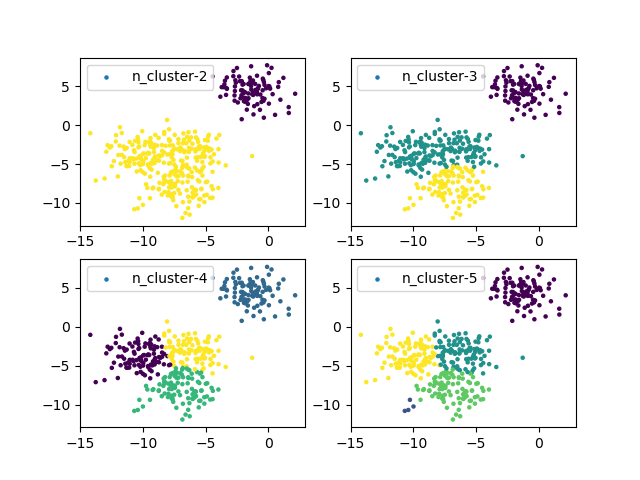

In [20]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2019-05-31 AAPL           -0.000701  34.632860  3.729628  3.836748  3.943868   
           ABBV           -0.028138  40.509218  4.087179  4.120630  4.154082   
           ABT            -0.004000  47.744544  4.223157  4.246252  4.269347   
           ACN            -0.002625  54.904820  5.066404  5.093782  5.121161   
           ADBE            0.000117  47.431756  5.595761  5.627233  5.658705   
...                             ...        ...       ...       ...       ...   
2025-05-31 VZ              0.000075  47.657027  3.762462  3.791511  3.820560   
           WDAY            0.000093  66.035757  5.368577  5.491662  5.614747   
           WFC             0.000205  62.935699  4.151715  4.260194  4.368673   
           WMT             0.000220  54.534919  4.527725  4.572275  4.616824   
           XOM             0.000068  52.842848  4.633090  4.669005  4.704921   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-05-31 AAPL   -1.451579 -0.780296  -0.124213  -0.038120   0.004969   
           ABBV    0.355169 -0.345994  -0.033758  -0.017923  -0.006405   
           ABT     0.499781 -0.476092  -0.043112  -0.022126  -0.005087   
           ACN     0.066913  0.003359  -0.025182   0.009963   0.036194   
           ADBE   -0.977400 -0.102993  -0.063440   0.008240   0.010555   
...                     ...       ...        ...        ...        ...   
2025-05-31 VZ     -1.781915 -0.010364  -0.032002  -0.022576   0.001814   
           WDAY    0.514480  1.479676   0.102122   0.075293   0.008385   
           WFC    -0.993850  1.680193   0.076002   0.031655  -0.008209   
           WMT    -0.575134  2.048463  -0.011704   0.046323  -0.007610   
           XOM    -1.357163 -0.390327   0.036259  -0.040639  -0.005631   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-05-31 AAPL    -0.001953  -0.027496   -0.004168  1.241761 -0.091725   
           ABBV    -0.029679  -0.020684   -0.017210  0.544509  0.159594   
           ABT      0.006087   0.016011    0.019370  0.781640 -0.046634   
           ACN      0.014672   0.007720    0.012691  1.162401 -0.181300   
           ADBE     0.012871   0.003078    0.006955  1.377014 -0.615795   
...                      ...        ...         ...       ...       ...   
2025-05-31 VZ      -0.000893   0.007763    0.008454  0.521610 -0.536201   
           WDAY     0.012929   0.002851    0.020585  1.163054 -0.635381   
           WFC      0.001339   0.031397    0.022017  1.079990 -0.159563   
           WMT      0.007236   0.025165    0.032802  0.663435 -0.295713   
           XOM     -0.010920  -0.006372   -0.003637  0.954852 -0.065126   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2019-05-31 AAPL   -0.688678  0.371845  0.412204        0  
           ABBV   -0.082435  0.296090  0.581139        3  
           ABT    -0.371989  0.087811  1.014484        2  
           ACN    -0.241814  0.249142 -0.029951        2  
           ADBE   -0.250568  0.296085 -0.415621        2  
...                     ...       ...       ...      ...  
2025-05-31 VZ      0.385963  0.156020  0.015711        3  
           WDAY   -0.318357 -0.951588 -0.464325        2  
           WFC     1.618781 -0.792944 -1.109369        2  
           WMT    -0.327358  0.248879  0.531931        1  
           XOM     0.932763 -0.385918  0.348994        3  

[10214 rows x 19 columns]

In [21]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

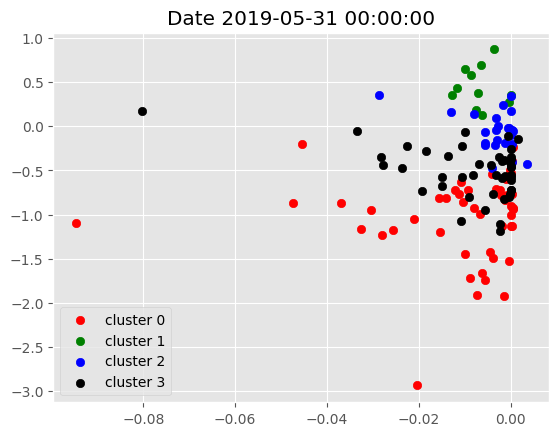

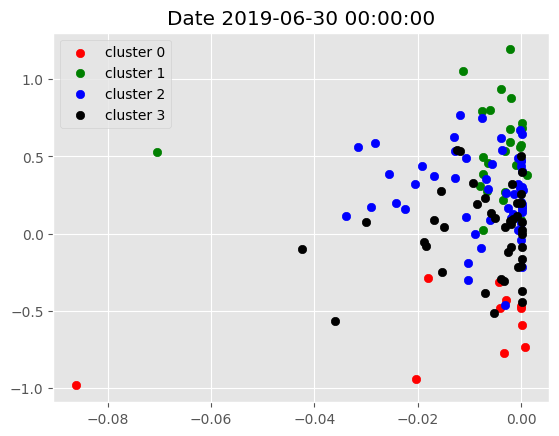

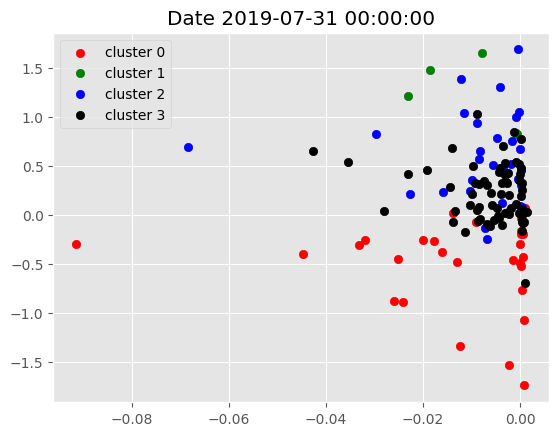

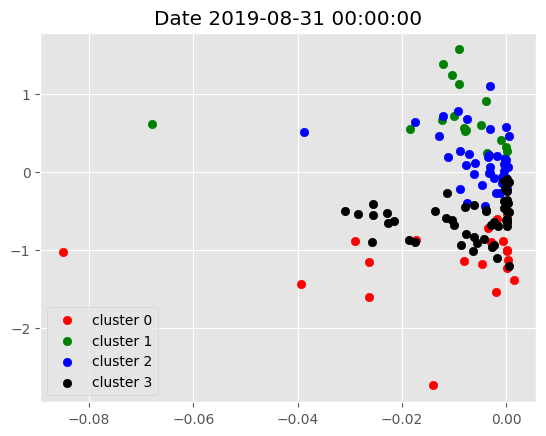

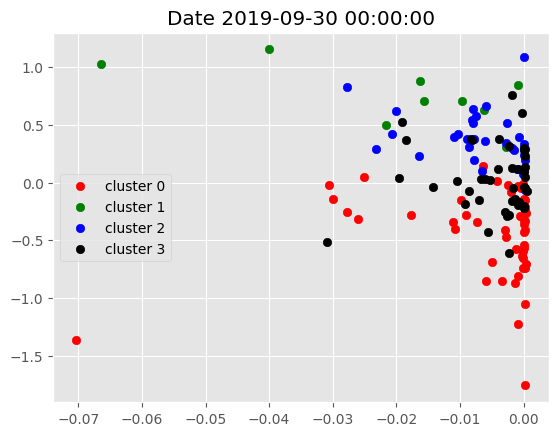

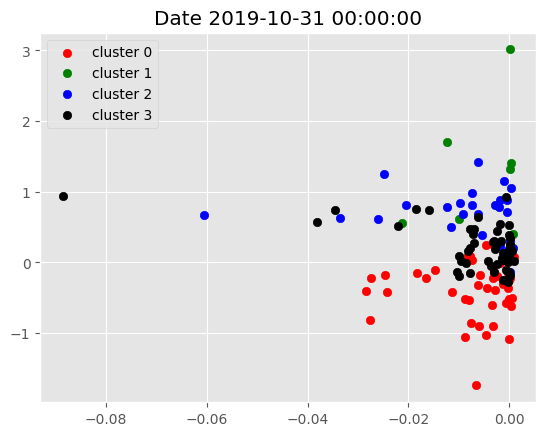

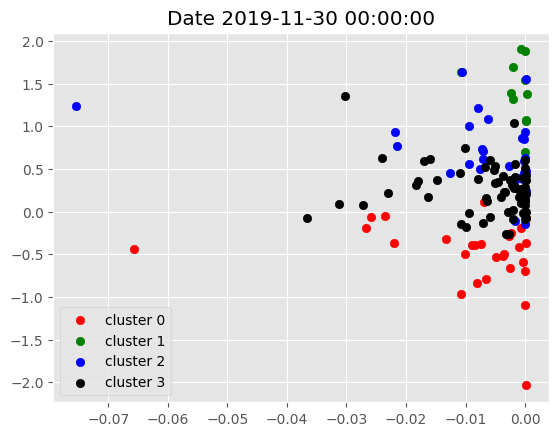

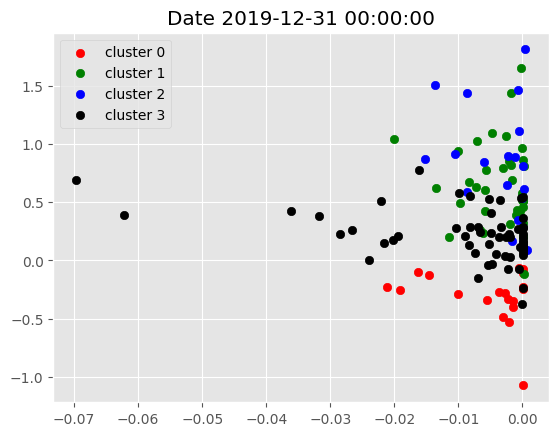

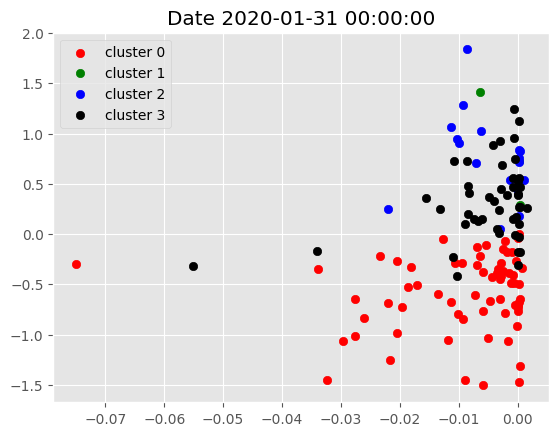

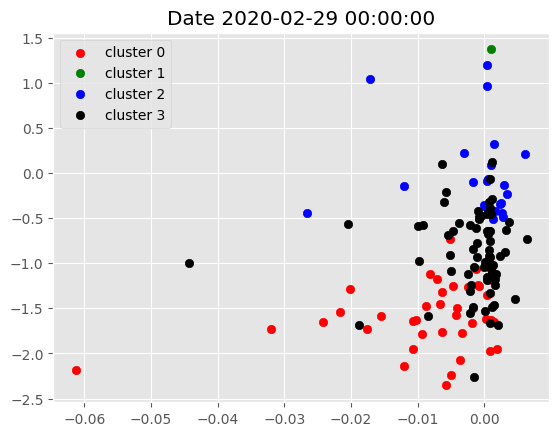

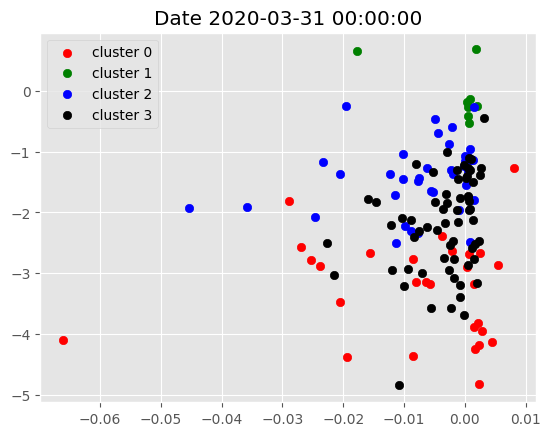

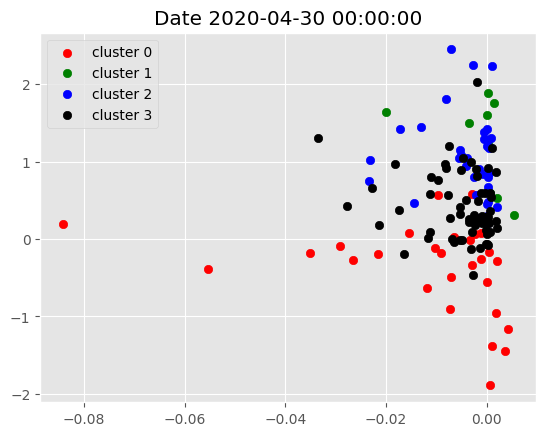

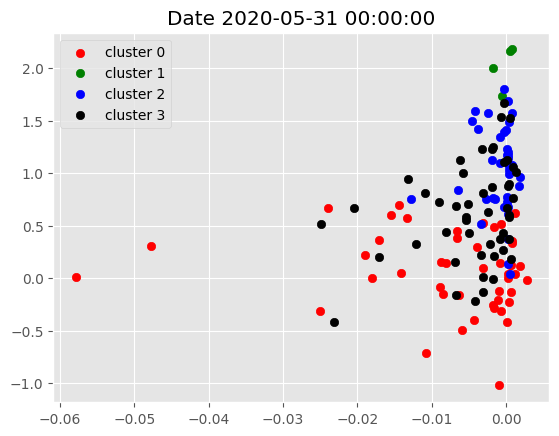

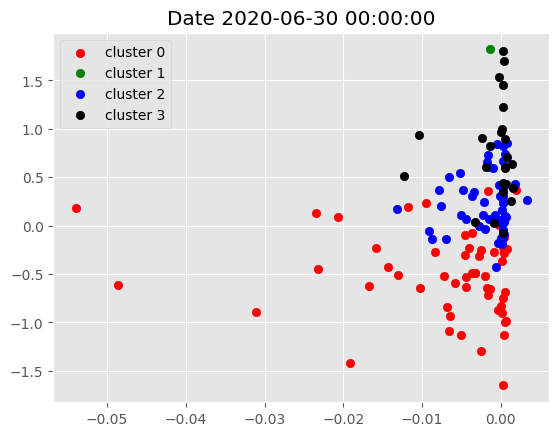

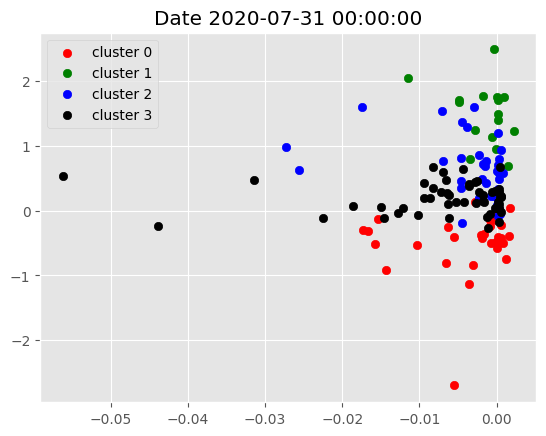

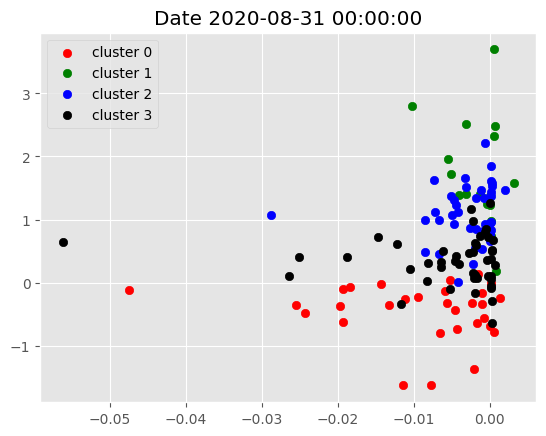

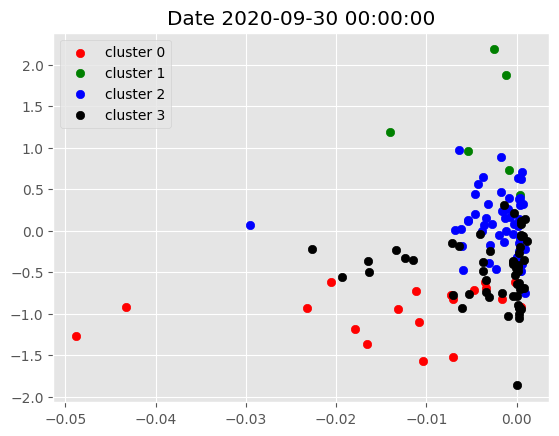

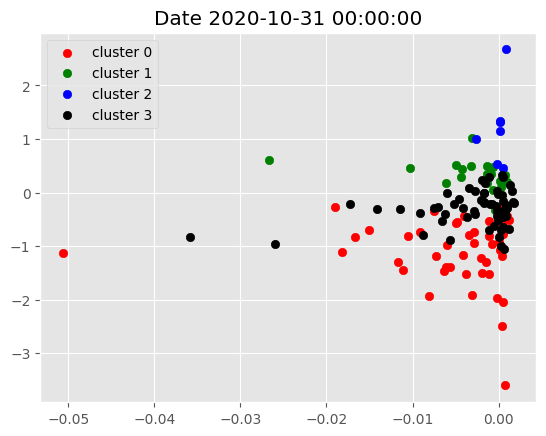

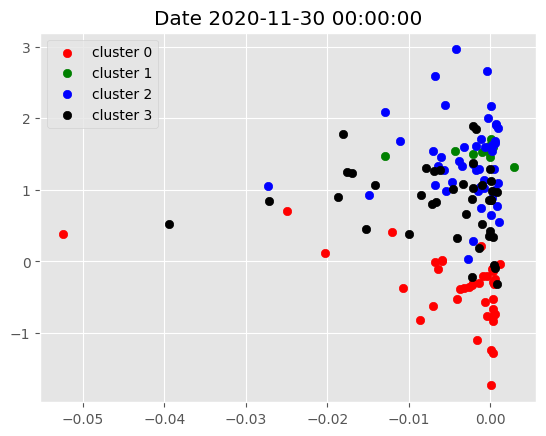

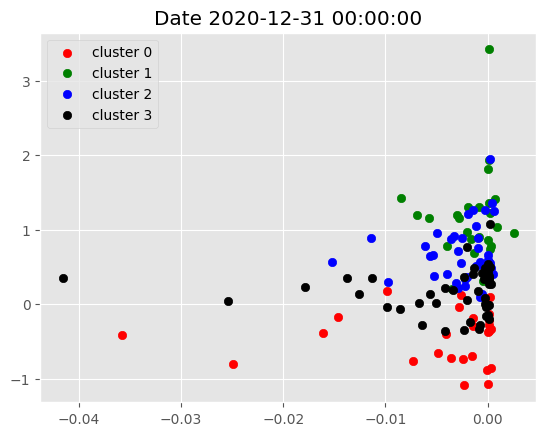

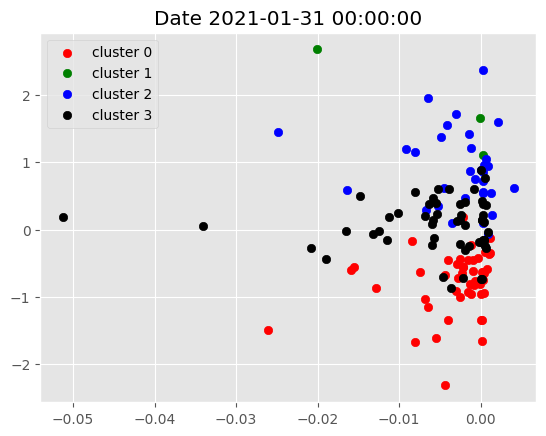

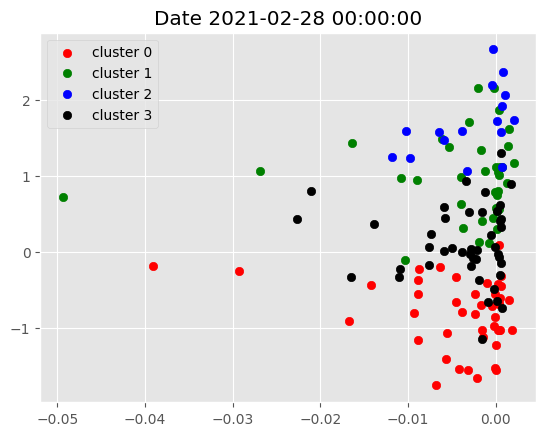

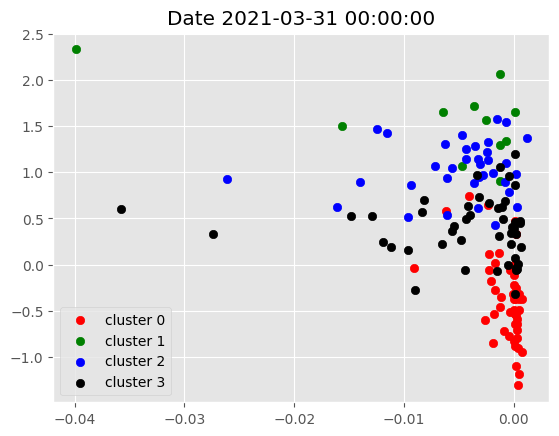

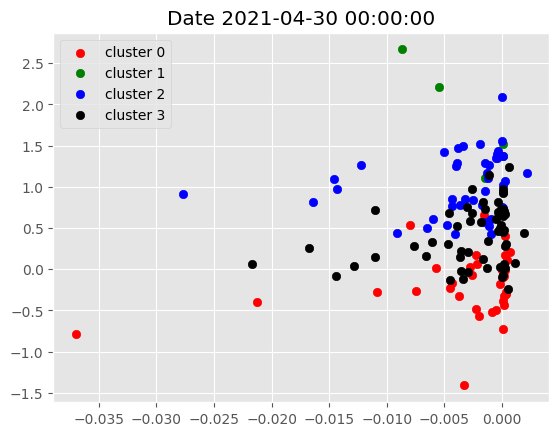

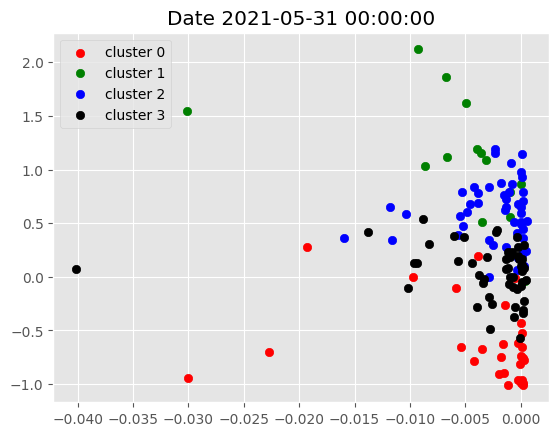

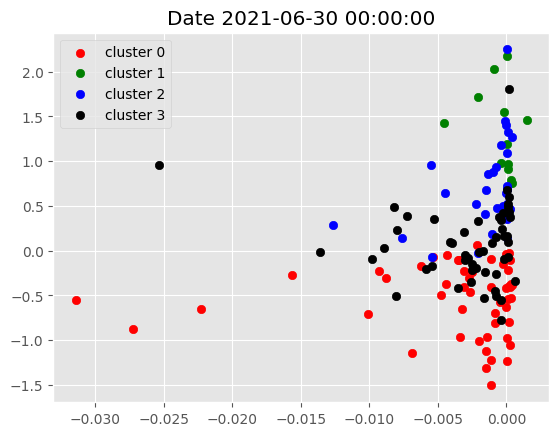

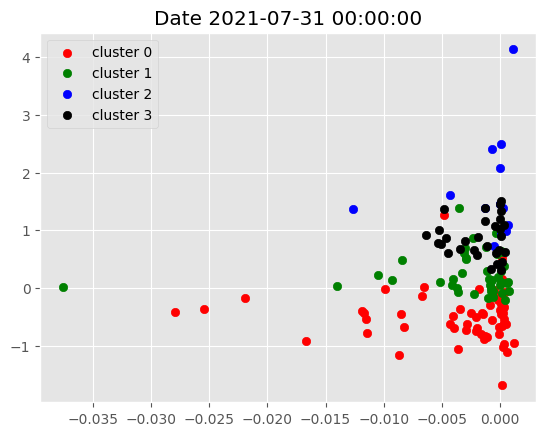

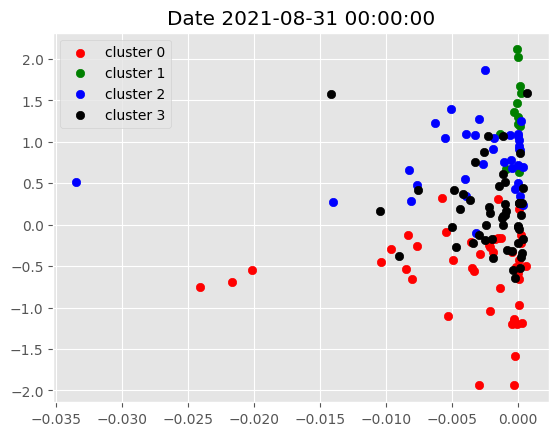

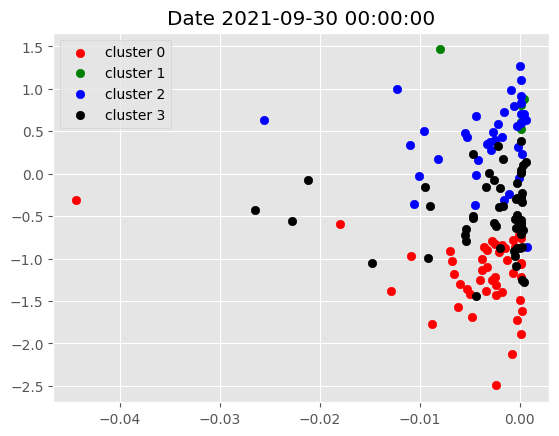

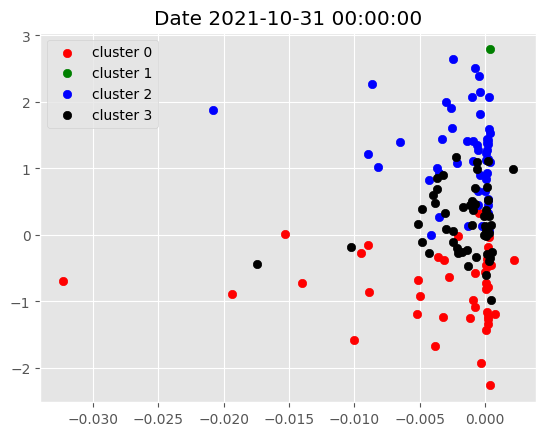

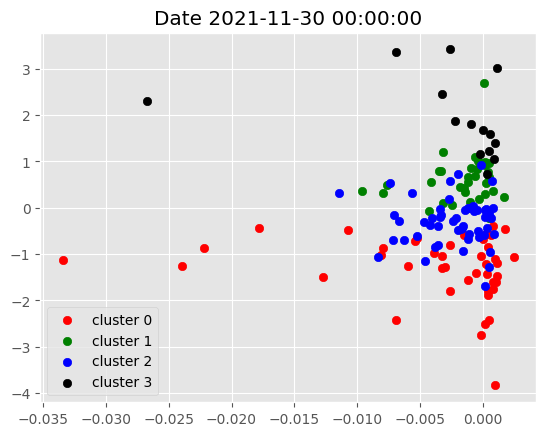

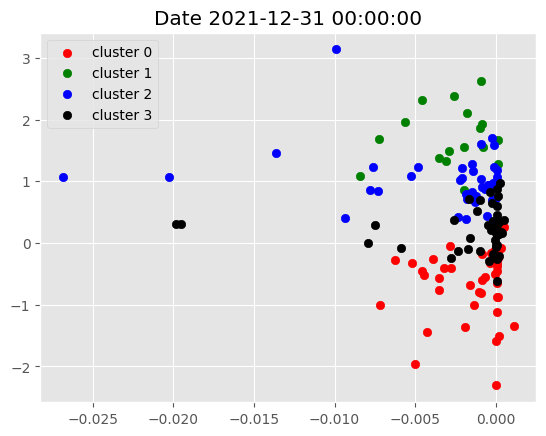

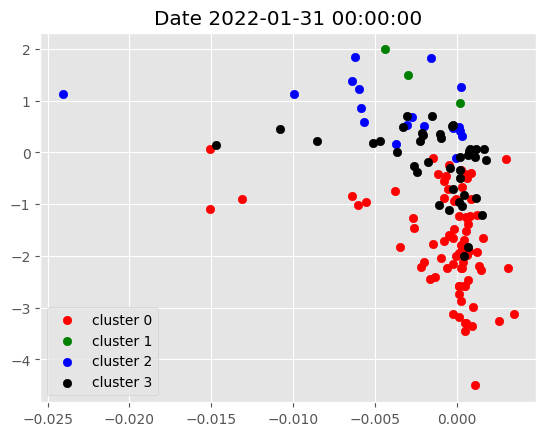

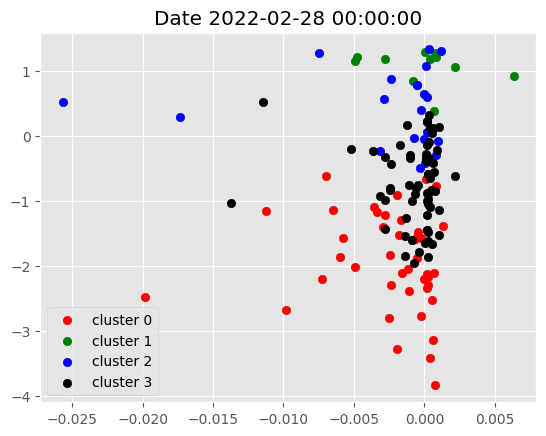

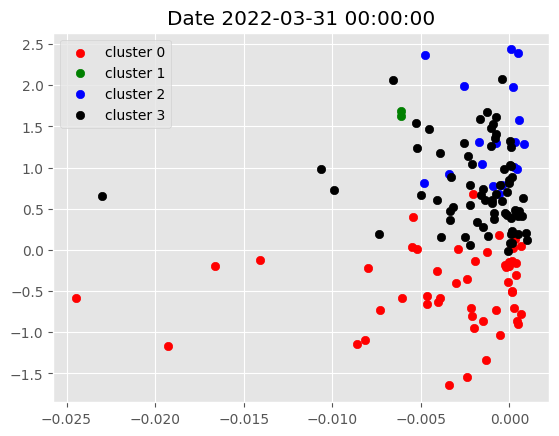

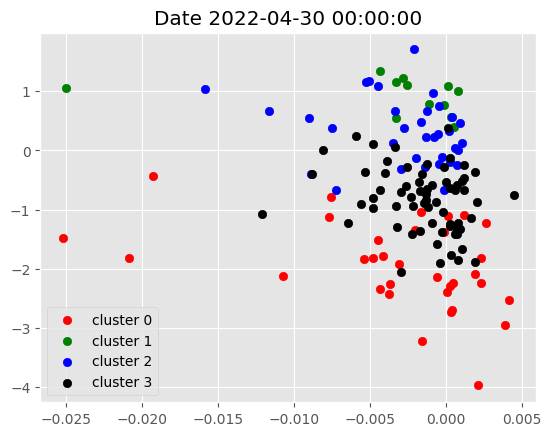

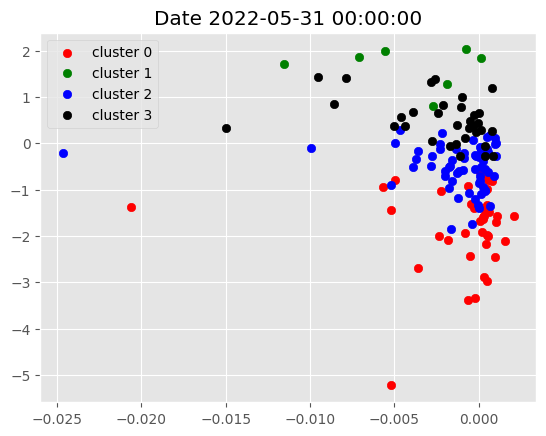

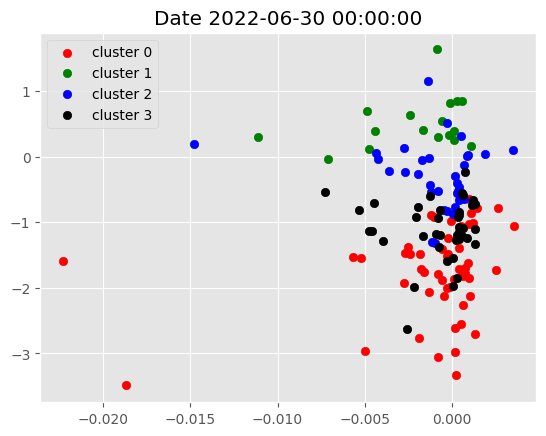

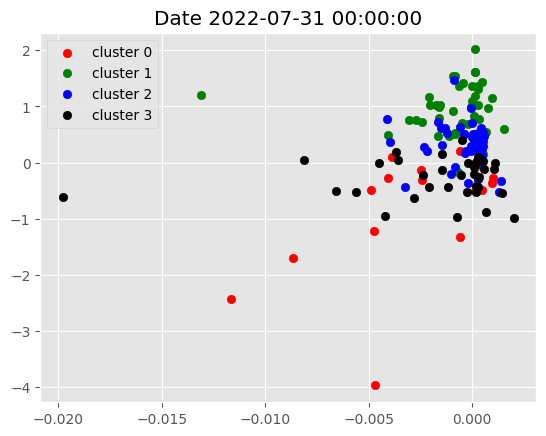

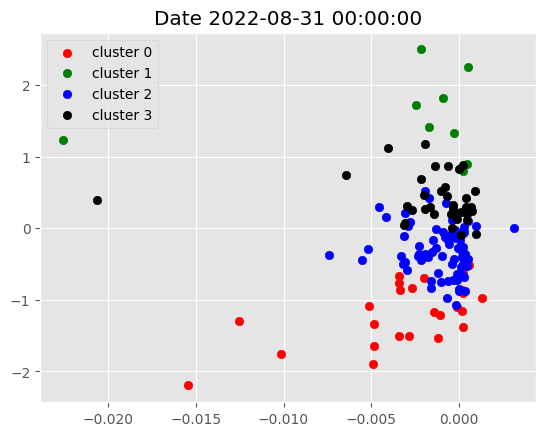

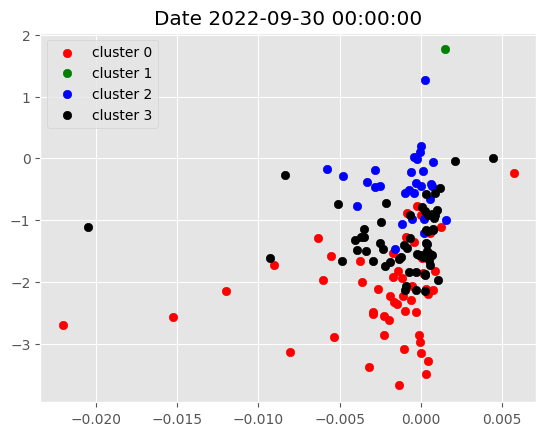

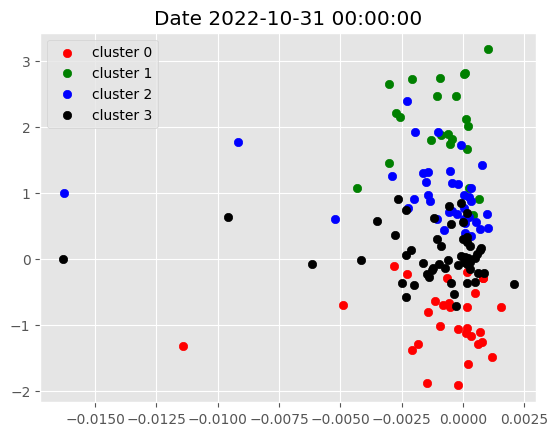

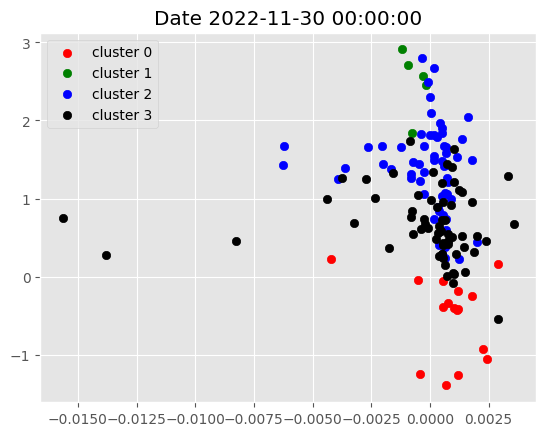

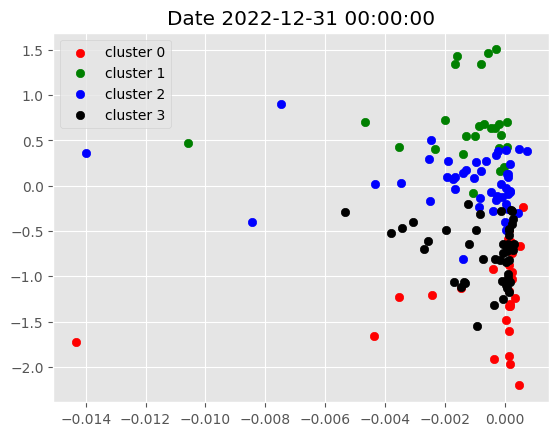

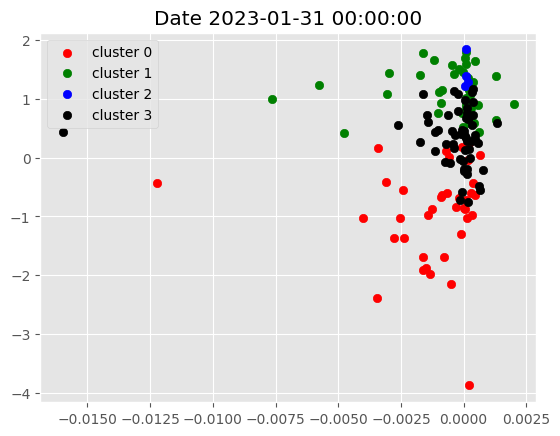

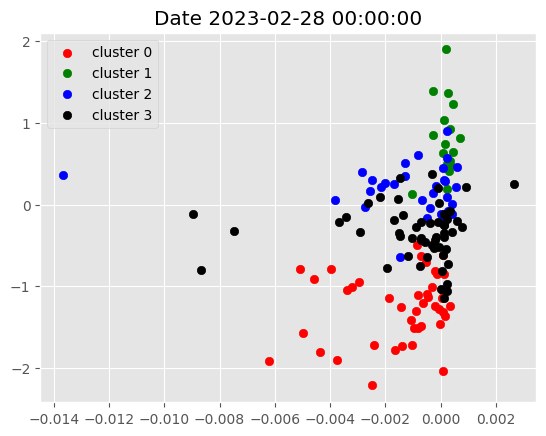

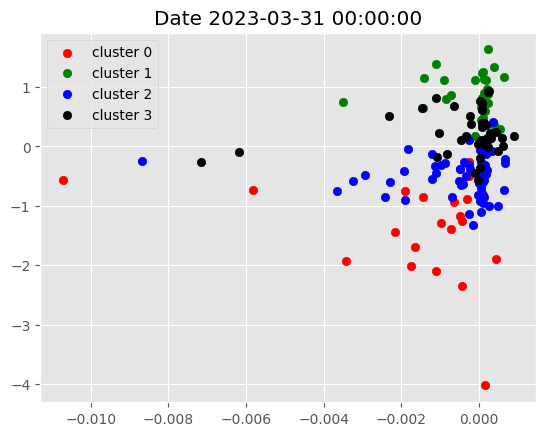

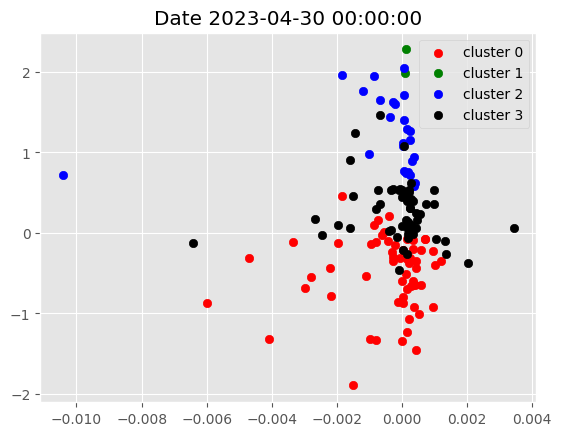

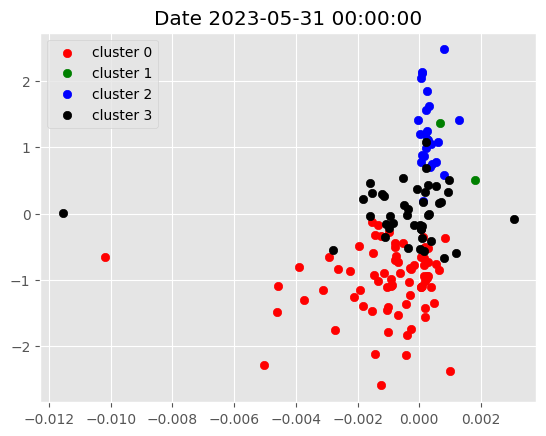

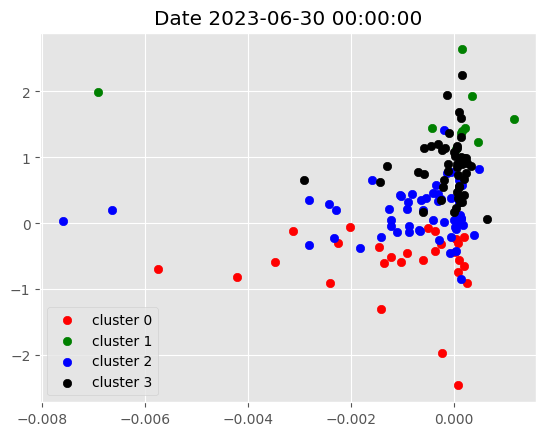

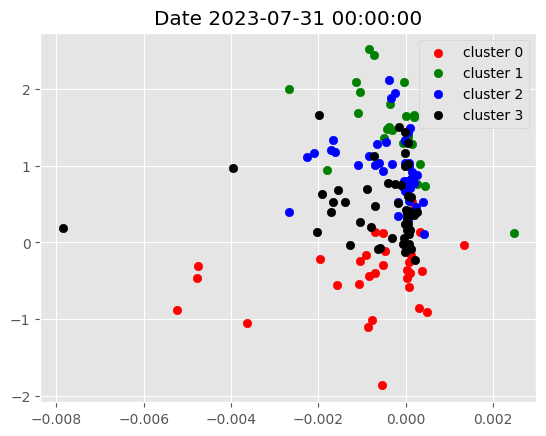

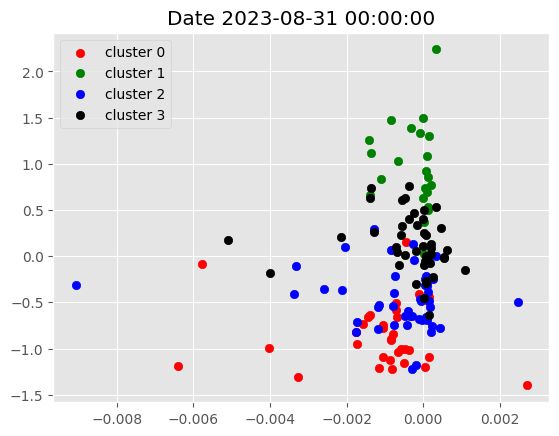

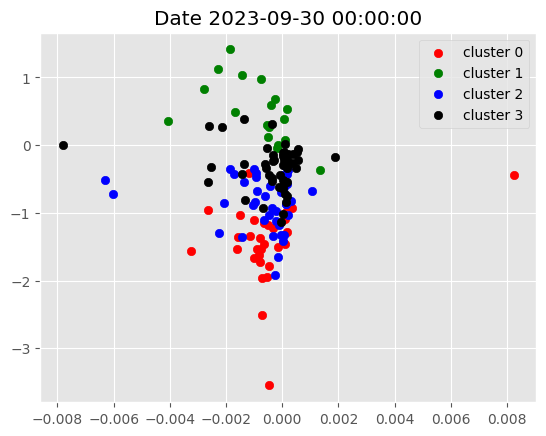

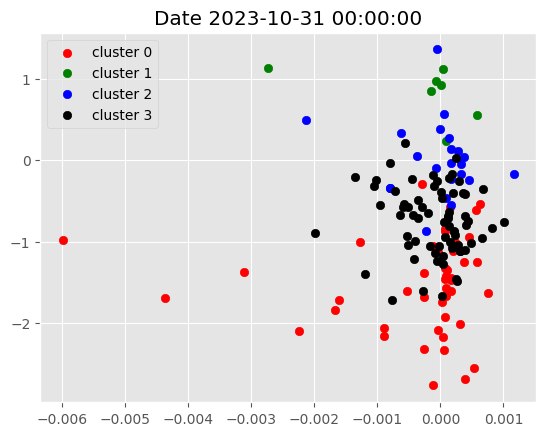

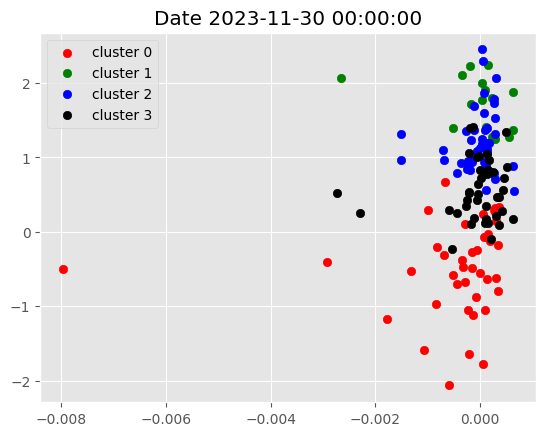

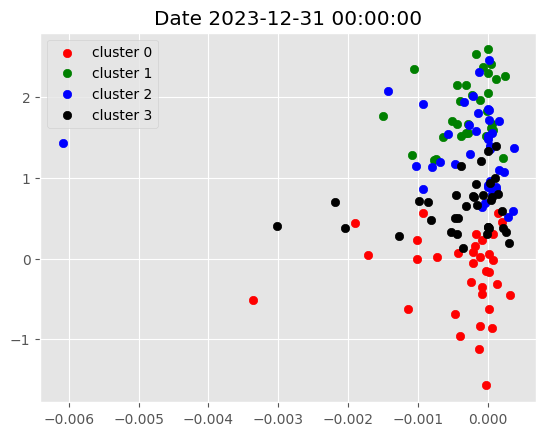

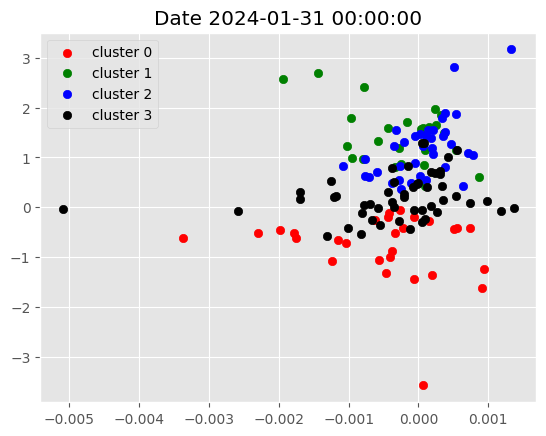

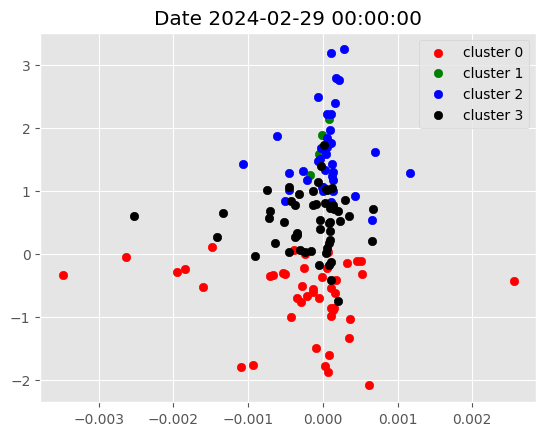

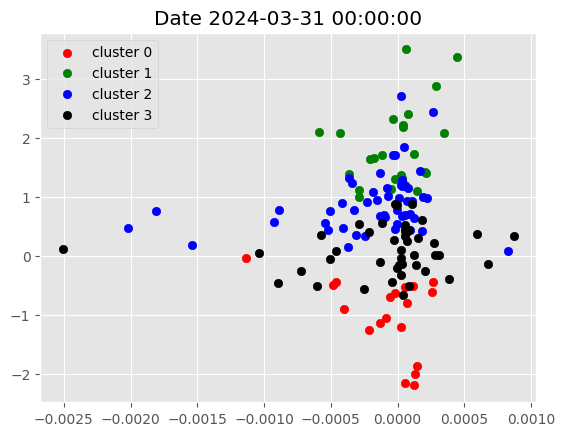

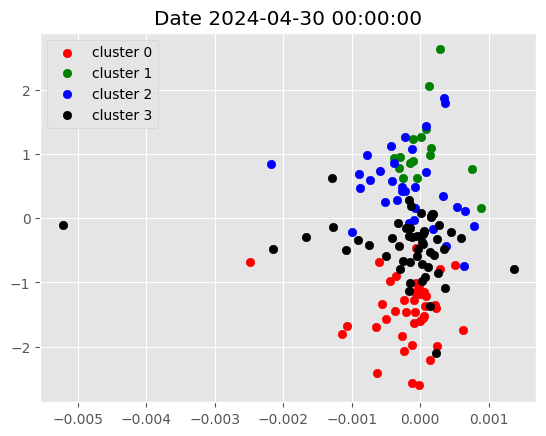

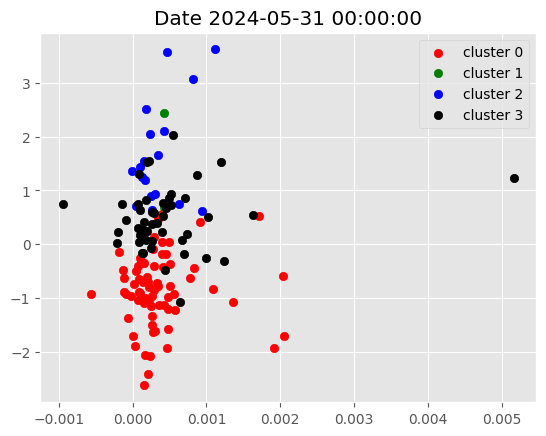

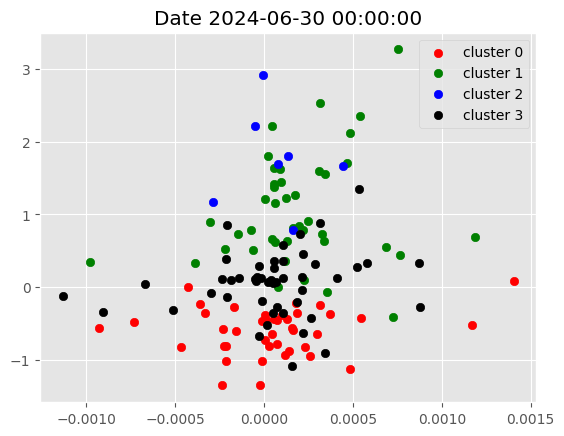

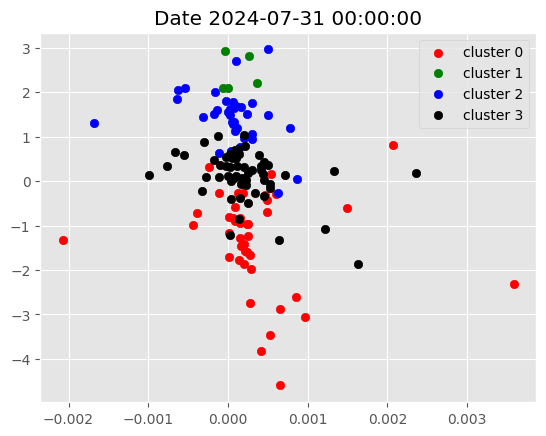

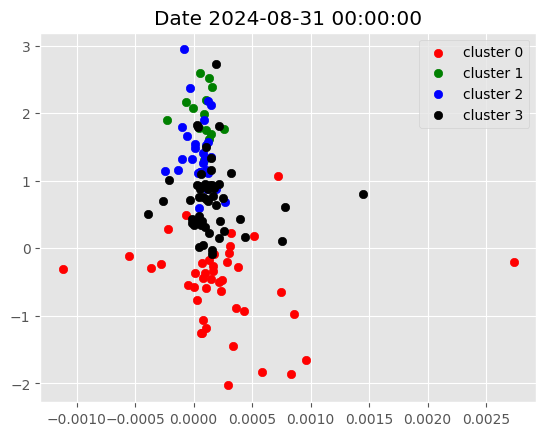

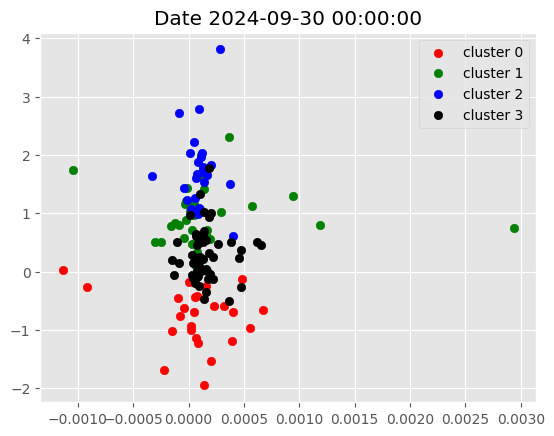

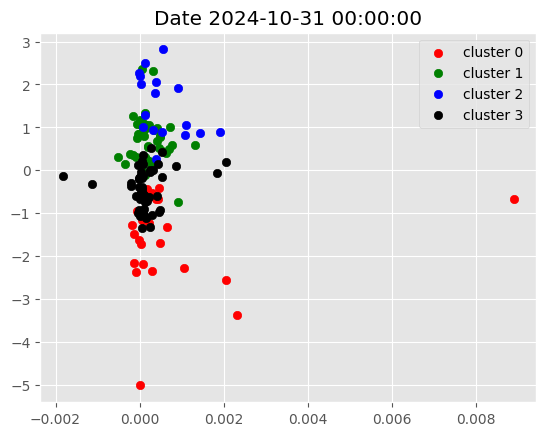

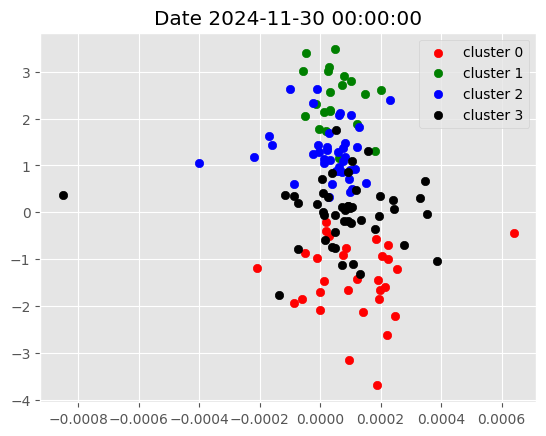

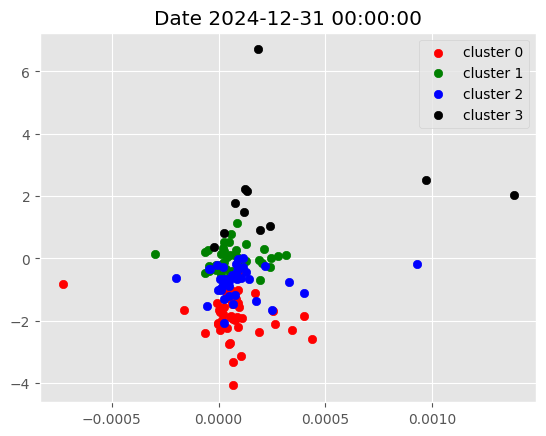

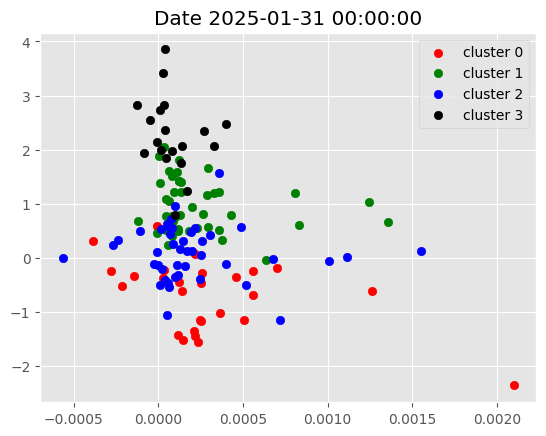

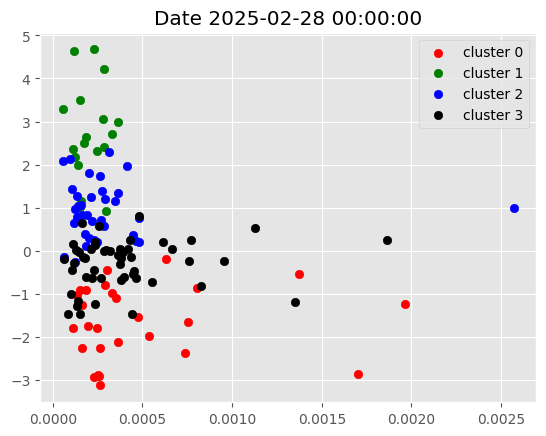

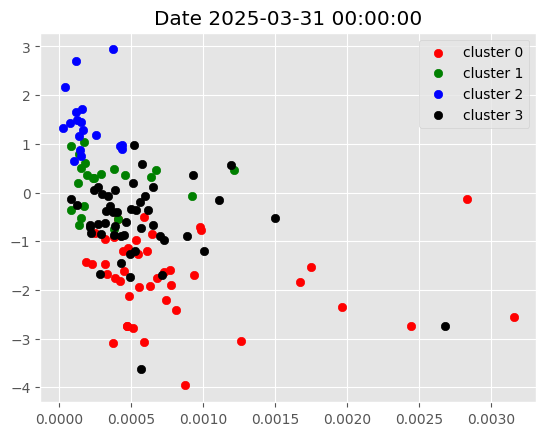

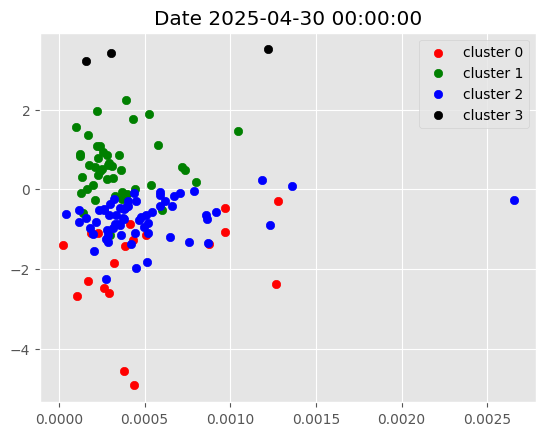

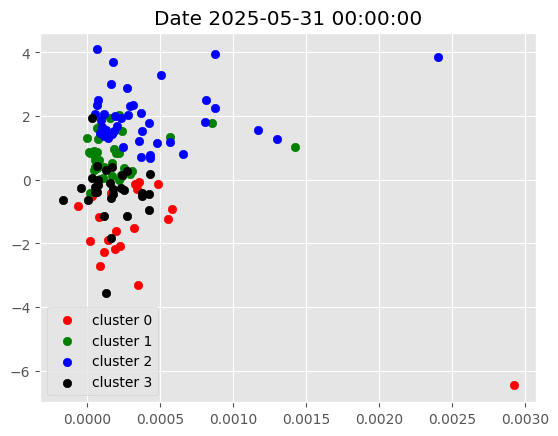

In [22]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

### Apply pre-defined centroids.

In [16]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

### 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
- First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

- Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [23]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2019-06-01': ['ABBV',
  'ADSK',
  'ALGN',
  'AMAT',
  'AMZN',
  'BA',
  'BMY',
  'C',
  'CI',
  'CMCSA',
  'CMG',
  'COP',
  'COST',
  'CRM',
  'CSCO',
  'CSX',
  'CVS',
  'CVX',
  'DE',
  'EBAY',
  'F',
  'GE',
  'GILD',
  'GOOG',
  'GOOGL',
  'HD',
  'HUM',
  'JPM',
  'LLY',
  'MAR',
  'META',
  'MGM',
  'NFLX',
  'NXPI',
  'PG',
  'QCOM',
  'RTX',
  'SCHW',
  'SHW',
  'T',
  'TJX',
  'TXN',
  'UNP',
  'USB',
  'VRTX'],
 '2019-07-01': ['ADP',
  'ADSK',
  'AMD',
  'AMT',
  'BA',
  'BIIB',
  'CI',
  'CMCSA',
  'COP',
  'CRM',
  'CSCO',
  'CSX',
  'CVS',
  'ELV',
  'FDX',
  'INTC',
  'JNJ',
  'LOW',
  'LRCX',
  'LUV',
  'MMM',
  'MS',
  'NFLX',
  'NKE',
  'NOW',
  'NXPI',
  'PEP',
  'PM',
  'PYPL',
  'REGN',
  'RTX',
  'SHW',
  'TJX',
  'TMUS',
  'TSLA',
  'ULTA',
  'UNH',
  'UNP',
  'UPS',
  'VZ',
  'WYNN',
  'XOM'],
 '2019-08-01': ['ACN',
  'ADBE',
  'ADP',
  'AVGO',
  'AXP',
  'AZO',
  'BDX',
  'BIIB',
  'BKNG',
  'BLK',
  'C',
  'CAT',
  'CI',
  'CMCSA',
  'CRM',
  'CVS',
  'CVX',

### Define portfolio optimization function
- We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

- To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

- Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [24]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

- Download Fresh Daily Prices Data only for short listed stocks.

In [50]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1],
                      auto_adjust=False)

new_df

[*********************100%***********************]  153 of 153 completed


Price        Adj Close                                                  \
Ticker            AAPL        ABBV        ABNB         ABT         ACN   
Date                                                                     
2018-05-31   44.204174   72.653076         NaN   54.458656  140.315765   
2018-06-01   45.001358   71.999542         NaN   55.237534  143.153809   
2018-06-04   45.377476   72.770538         NaN   55.777424  143.640244   
2018-06-05   45.727551   72.873383         NaN   55.786285  144.081772   
2018-06-06   45.886051   73.416771         NaN   56.237671  146.595474   
...                ...         ...         ...         ...         ...   
2025-05-23  195.270004  183.259995  126.720001  131.300003  309.579987   
2025-05-27  200.210007  185.720001  129.399994  132.940002  315.429993   
2025-05-28  200.419998  183.089996  128.669998  132.020004  315.989990   
2025-05-29  199.949997  185.619995  128.360001  132.850006  317.730011   
2025-05-30  200.850006  186.110001  129.000000  133.580002  316.820007   

Price                                                                   ...  \
Ticker            ADBE         ADI         ADP        ADSK        ALGN  ...   
Date                                                                    ...   
2018-05-31  249.279999   85.249046  112.242447  129.100006  331.950012  ...   
2018-06-01  251.309998   86.319244  114.581932  133.520004  333.089996  ...   
2018-06-04  253.339996   87.705246  115.894089  135.570007  343.200012  ...   
2018-06-05  252.699997   88.284233  115.738716  136.800003  346.079987  ...   
2018-06-06  253.949997   89.564995  117.491142  137.929993  346.369995  ...   
...                ...         ...         ...         ...         ...  ...   
2025-05-23  407.690002  210.470001  321.089996  295.350006  170.800003  ...   
2025-05-27  413.100006  216.889999  325.709991  300.359985  178.550003  ...   
2025-05-28  412.230011  215.619995  324.140015  299.230011  180.110001  ...   
2025-05-29  413.359985  215.750000  324.119995  297.000000  183.050003  ...   
2025-05-30  415.089996  213.979996  325.529999  296.119995  180.940002  ...   

Price        Volume                                                           \
Ticker          VLO     VRTX        VZ       WBA     WDAY      WDC       WFC   
Date                                                                           
2018-05-31  5480900  1649400  27288300   6508700  2806000  6477540  17515900   
2018-06-01  2941900  2176800   9967100   3225500  5722200  4959530  14100200   
2018-06-04  3792000  2661000   9012600   3564200  3012500  5607271  10593700   
2018-06-05  3392500  2957800  10378000   6999100  1776700  3772005  11883900   
2018-06-06  3554200  3087500  12924800   5455600  2365900  6355692  15848200   
...             ...      ...       ...       ...      ...      ...       ...   
2025-05-23  2053000  1427300  12393400   9769700  9915000  5763200   9260900   
2025-05-27  2426400  2048300  12873700  10568700  4740700  6374500  11014100   
2025-05-28  3125200  1209500  12783000   8662100  2721700  6782100   8711100   
2025-05-29  2567600   882500   9960400   8877200  2991400  4570900  14016600   
2025-05-30  3870500  2581700  26553600  69211300  3490400  7402300  17037900   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2018-05-31  34406100  2240500  15803100  
2018-06-01  15713700  3732500   9906100  
2018-06-04  32766000  5783500  10954700  
2018-06-05  24844200  7194500  12059300  
2018-06-06  22088400  5006900  11603300  
...              ...      ...       ...  
2025-05-23  13668600  1335800  12061600  
2025-05-27  17180900  1813400  13043600  
2025-05-28  11220100  1405600  14292400  
2025-05-29  14338000  2208400  13825300  
2025-05-30  29969600  6827900  28637300  

[1760 rows x 918 columns]

- Calculate daily returns for each stock which could land up in our portfolio.

- Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

- If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

- Calculated each day portfolio return.

In [53]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:
        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]
        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        # Verificar que las columnas existen
        available_cols = [col for col in cols if col in new_df['Adj Close'].columns]
        if len(available_cols) == 0:
            print(f'No stocks available for {start_date}')
            continue
            
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][available_cols]
        
        # Eliminar columnas con todos NaN
        optimization_df = optimization_df.dropna(axis=1, how='all')
        
        if optimization_df.empty or len(optimization_df.columns) == 0:
            print(f'No data available for optimization in {start_date}')
            continue
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))
            
            # Convertir weights a DataFrame correctamente
            weights_df = pd.DataFrame.from_dict(weights, orient='index', columns=['weight'])
            success = True
            print(f'Max Sharpe Optimization successful for {start_date}')
            
        except Exception as e:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights: {e}')
        
        if success==False:
            # Crear pesos iguales para todas las columnas disponibles
            equal_weight = 1/len(optimization_df.columns)
            weights_df = pd.DataFrame(index=optimization_df.columns, 
                                    data=[equal_weight]*len(optimization_df.columns), 
                                    columns=['weight'])
        
        # Calcular returns para el período
        temp_returns = returns_dataframe[start_date:end_date]
        
        # Solo usar stocks que tenemos pesos
        available_stocks = list(set(temp_returns.columns) & set(weights_df.index))
        
        if len(available_stocks) == 0:
            print(f'No matching stocks for {start_date}')
            continue
            
        # Filtrar returns y weights para stocks disponibles
        temp_returns = temp_returns[available_stocks]
        weights_filtered = weights_df.loc[available_stocks]
        
        # Calcular portfolio returns diarios
        portfolio_returns = (temp_returns * weights_filtered['weight']).sum(axis=1)
        
        # Agregar al DataFrame principal
        temp_portfolio = portfolio_returns.to_frame('Strategy Return')
        portfolio_df = pd.concat([portfolio_df, temp_portfolio], axis=0)
    
    except Exception as e:
        print(f'Error processing {start_date}: {e}')

# Limpiar duplicados y ordenar
portfolio_df = portfolio_df.drop_duplicates().sort_index()

print(f"\nPortfolio DataFrame shape: {portfolio_df.shape}")
print(f"Date range: {portfolio_df.index.min()} to {portfolio_df.index.max()}")
print(f"Sample data:")
print(portfolio_df.head())

portfolio_df

Max Sharpe Optimization successful for 2019-06-01
Max Sharpe Optimization successful for 2019-07-01
Max Sharpe Optimization successful for 2019-08-01
Max Sharpe Optimization successful for 2019-09-01
Max Sharpe Optimization successful for 2019-10-01
Max Sharpe Optimization successful for 2019-11-01
Max Sharpe Optimization successful for 2019-12-01
Max Sharpe Optimization successful for 2020-01-01
Max Sharpe Optimization successful for 2020-02-01
Max Sharpe Optimization successful for 2020-03-01
Max Sharpe Optimization successful for 2020-04-01
Max Sharpe Optimization successful for 2020-05-01
Max Sharpe Optimization successful for 2020-06-01
Max Sharpe Optimization successful for 2020-07-01
Max Sharpe Optimization successful for 2020-08-01
Max Sharpe Optimization successful for 2020-09-01
Max Sharpe Optimization successful for 2020-10-01
Max Sharpe Optimization successful for 2020-11-01
Max Sharpe Optimization successful for 2020-12-01
Max Sharpe Optimization successful for 2021-01-01


Strategy Return
Date                       
2019-06-03        -0.003085
2019-06-04         0.021385
2019-06-05         0.007325
2019-06-06         0.005852
2019-06-07         0.012745
...                     ...
2025-05-23         0.007628
2025-05-27         0.009438
2025-05-28        -0.000653
2025-05-29        -0.012220
2025-05-30         0.036124

[1508 rows x 1 columns]

<Axes: xlabel='Date'>

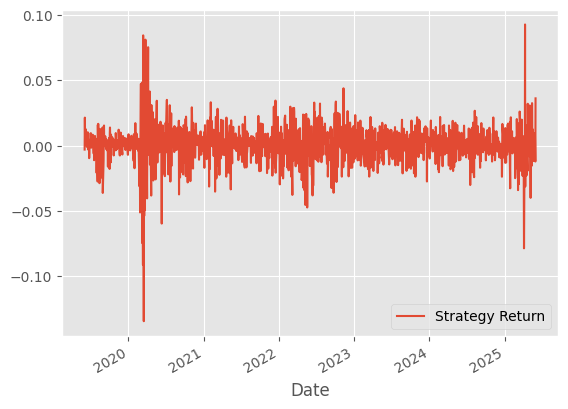

In [54]:
portfolio_df.plot()

### 8. Visualize Portfolio returns and compare to SP500 returns.

In [75]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today(),
                  auto_adjust=False)  # Para obtener Adj Close

print(f"Columnas de SPY: {spy.columns.tolist()}")

# Para un solo ticker, acceder directamente a la columna
if 'Adj Close' in spy.columns:
    spy_prices = spy['Adj Close']
    print("✓ Usando 'Adj Close' de SPY")
else:
    spy_prices = spy['Close']
    print("✓ Usando 'Close' de SPY (Adj Close no disponible)")

# Calcular returns y convertir a DataFrame
spy_ret = np.log(spy_prices).diff().dropna()

# Verificar tipo antes de convertir
if isinstance(spy_ret, pd.Series):
    spy_ret = spy_ret.to_frame('SPY Buy&Hold')
else:
    spy_ret.columns = ['SPY Buy&Hold']

#print(f"\nEstructura de SPY returns:")
#print(spy_ret.head())

# Verificar si la columna ya existe antes del merge
if 'SPY Buy&Hold' in portfolio_df.columns:
    print("✓ La columna 'SPY Buy&Hold' ya existe en portfolio_df")
    #print(f"\nPortfolio final con SPY:")
    #print(portfolio_df.head())
else:
    # Hacer merge con portfolio_df
    portfolio_df = portfolio_df.merge(spy_ret,
                                      left_index=True,
                                      right_index=True,
                                      how='left')
    
    #print(f"\nPortfolio final con SPY:")
    #print(portfolio_df.head())

portfolio_df

# Filtrar solo las columnas necesarias
portfolio_df_final = portfolio_df[['Strategy Return', 'SPY Buy&Hold']].copy()

#print(f"Columnas finales: {portfolio_df_final.columns.tolist()}")
#print(f"Forma del DataFrame final: {portfolio_df_final.shape}")
#print(f"\nPrimeras filas:")
portfolio_df_final

[*********************100%***********************]  1 of 1 completed

Columnas de SPY: [('Adj Close', 'SPY'), ('Close', 'SPY'), ('High', 'SPY'), ('Low', 'SPY'), ('Open', 'SPY'), ('Volume', 'SPY')]
✓ Usando 'Adj Close' de SPY
✓ La columna 'SPY Buy&Hold' ya existe en portfolio_df


Strategy Return  SPY Buy&Hold
Date                                     
2019-06-03        -0.003085     -0.002546
2019-06-04         0.021385      0.021474
2019-06-05         0.007325      0.008625
2019-06-06         0.005852      0.006482
2019-06-07         0.012745      0.009957
...                     ...           ...
2025-05-23         0.007628     -0.006849
2025-05-27         0.009438      0.020577
2025-05-28        -0.000653     -0.005802
2025-05-29        -0.012220      0.003940
2025-05-30         0.036124     -0.001119

[1508 rows x 2 columns]

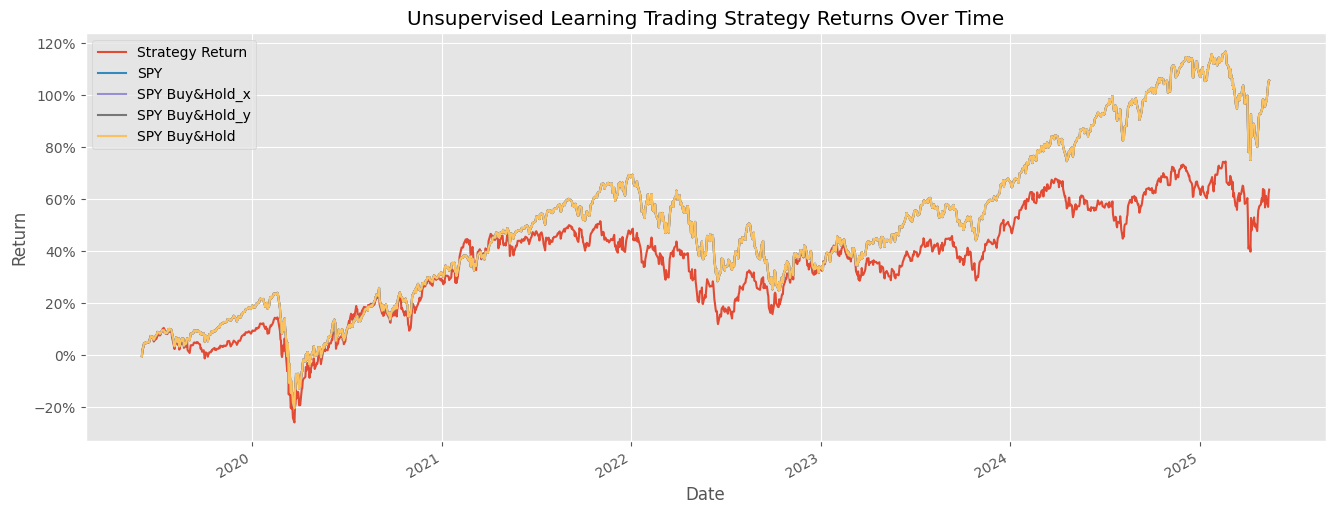

In [77]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2025-05-14'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

## Twitter Sentiment Investing Strategy
###  1. Load Twitter Sentiment Data
- Load the twitter sentiment dataset, set the index, calculat engagement ratio and filter out stocks with no significant twitter activity.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os
plt.style.use('ggplot')

data_folder = 'C:/Users/ASUS/Desktop/Juanes/Infraestructura/Proyecto-test1'

sentiment_df = pd.read_csv(os.path.join(data_folder, 'sentiment_data.csv'))

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

sentiment_df = sentiment_df.set_index(['date', 'symbol'])

sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']

sentiment_df = sentiment_df[(sentiment_df['twitterLikes']>20)&(sentiment_df['twitterComments']>10)]

sentiment_df


twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

## 2. Aggregate Monthly and calculate average sentiment for the month
- Aggregate on a monthly level and calculate average monthly metric, for the one we choose.

In [2]:
aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='ME'), 'symbol'])
                    [['engagement_ratio']].mean())

aggragated_df['rank'] = (aggragated_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))

aggragated_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

### 3. Select Top 5 Stocks based on their cross-sectional ranking for each month
- Select top 5 stocks by rank for each month and fix the date to start at beginning of next month.

In [3]:
filtered_df = aggragated_df[aggragated_df['rank']<6].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

filtered_df.head(20)

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
2022-01-01 D               0.801994   5.0
           FCX             0.841220   4.0
           L               6.507246   1.0
           LUV             1.303215   2.0
           MA              0.883401   3.0
2022-02-01 AMD             0.715556   4.0
           D               1.136678   1.0
           FCX             0.655237   5.0
           LUV             1.035258   2.0
           MA              0.729063   3.0
2022-03-01 FCX             1.138332   2.0
           GILD            0.530886   5.0
           LUV             1.574377   1.0
           MRO             0.581748   4.0
           OXY             1.025579   3.0

### 4. Extract the stocks to form portfolios with at the start of each new month
- Create a dictionary containing start of month and corresponded selected stocks.

In [4]:
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

### 5. Download fresh stock prices for only selected/shortlisted stocks

In [5]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()

# Filtrar acciones conocidas como problemáticas
problematic_stocks = ['ATVI', 'MRO', 'BF.B', 'BRK.B']  # Lista de acciones con problemas conocidos
stocks_list_clean = [stock for stock in stocks_list if stock not in problematic_stocks]

print(f"Acciones originales: {len(stocks_list)}")
print(f"Acciones después de filtrar: {len(stocks_list_clean)}")
print(f"Acciones filtradas: {[stock for stock in stocks_list if stock in problematic_stocks]}")

try:
    prices_df = yf.download(tickers=stocks_list_clean,
                            start='2021-01-01',
                            end='2023-03-01',
                            group_by='ticker',
                            auto_adjust=False,
                            prepost=True,
                            threads=True)
    
    print(f"✓ Descarga exitosa para {len(stocks_list_clean)} acciones")
    
except Exception as e:
    print(f"❌ Error en descarga: {e}")
    print("Intentando descarga individual...")
    
    # Descarga individual como respaldo
    individual_data = {}
    for stock in stocks_list_clean[:10]:  # Limitar a 10 para prueba
        try:
            data = yf.download(stock, start='2021-01-01', end='2023-03-01')
            if not data.empty:
                individual_data[stock] = data
        except:
            continue
    
    if individual_data:
        prices_df = pd.concat(individual_data, axis=1)
        print(f"✓ Descarga individual exitosa para {len(individual_data)} acciones")

prices_df

Acciones originales: 85
Acciones después de filtrar: 83
Acciones filtradas: ['ATVI', 'MRO']


[*********************100%***********************]  83 of 83 completed

✓ Descarga exitosa para 83 acciones


Ticker             CRM                                                  \
Price             Open        High         Low       Close   Adj Close   
Date                                                                     
2021-01-04  222.639999  223.750000  215.720001  220.309998  218.396286   
2021-01-05  219.490005  223.000000  217.990005  221.520004  219.595795   
2021-01-06  218.000000  220.460007  215.779999  216.149994  214.272415   
2021-01-07  217.029999  220.660004  216.500000  217.979996  216.086517   
2021-01-08  220.000000  222.320007  219.220001  222.039993  220.111252   
...                ...         ...         ...         ...         ...   
2023-02-22  163.110001  165.000000  162.110001  163.360001  161.940979   
2023-02-23  165.289993  165.470001  161.570007  164.119995  162.694366   
2023-02-24  160.589996  162.389999  159.660004  162.199997  160.791092   
2023-02-27  163.839996  164.770004  162.220001  163.139999  161.722900   
2023-02-28  162.529999  164.449997  161.529999  163.610001  162.188828   

Ticker                         A                                      ...  \
Price         Volume        Open        High         Low       Close  ...   
Date                                                                  ...   
2021-01-04  10319900  118.940002  120.089996  117.110001  118.639999  ...   
2021-01-05   8657200  118.480003  120.320000  118.070000  119.610001  ...   
2021-01-06   9789800  118.690002  123.879997  118.209999  122.889999  ...   
2021-01-07   8443100  124.330002  127.480003  124.110001  126.160004  ...   
2021-01-08   7301700  126.489998  127.639999  125.849998  127.059998  ...   
...              ...         ...         ...         ...         ...  ...   
2023-02-22   4343700  143.369995  143.440002  140.949997  142.080002  ...   
2023-02-23   4679400  142.089996  143.580002  141.309998  143.199997  ...   
2023-02-24   6569900  141.460007  142.240005  138.720001  141.199997  ...   
2023-02-27   6891200  142.880005  143.759995  141.809998  142.179993  ...   
2023-02-28   6912600  141.750000  143.380005  141.389999  141.970001  ...   

Ticker            CCL                                       INTC             \
Price             Low      Close  Adj Close    Volume       Open       High   
Date                                                                          
2021-01-04  20.040001  20.379999  20.379999  40642500  49.889999  51.389999   
2021-01-05  20.150000  20.600000  20.600000  32464400  49.450001  50.830002   
2021-01-06  20.160000  20.400000  20.400000  35295900  50.439999  52.150002   
2021-01-07  20.469999  20.740000  20.740000  28989000  51.490002  52.689999   
2021-01-08  20.180000  20.469999  20.469999  30370000  52.450001  52.529999   
...               ...        ...        ...       ...        ...        ...   
2023-02-22  10.880000  11.040000  11.040000  25605800  25.910000  26.900000   
2023-02-23  10.670000  10.890000  10.890000  28657500  25.780001  26.080000   
2023-02-24  10.380000  10.590000  10.590000  32077800  25.219999  25.350000   
2023-02-27  10.760000  10.830000  10.830000  23336700  25.549999  25.580000   
2023-02-28  10.250000  10.620000  10.620000  39800000  24.940001  25.120001   

Ticker                                                 
Price             Low      Close  Adj Close    Volume  
Date                                                   
2021-01-04  49.400002  49.669998  44.902927  46102500  
2021-01-05  49.330002  50.610001  45.752716  24866600  
2021-01-06  50.200001  51.099998  46.195698  36809600  
2021-01-07  51.299999  52.189999  47.181080  32092300  
2021-01-08  51.270000  51.650002  46.692913  34625400  
...               ...        ...        ...       ...  
2023-02-22  25.299999  25.469999  24.859419  89195300  
2023-02-23  25.320000  25.610001  24.996065  56473200  
2023-02-24  24.920000  25.139999  24.537329  44089900  
2023-02-27  24.879999  24.900000  24.303082  37657000  
2023-02-28  24.730000  24.930000  24.332365  5025

### 6. Calculate Portfolio Returns with monthly rebalancing

In [7]:
# CELDA 52 CORREGIDA - Manejo robusto de estructura de datos

print("=== DIAGNÓSTICO DE ESTRUCTURA DE DATOS ===")

# 1. Analizar la estructura de prices_df
print(f"Forma de prices_df: {prices_df.shape}")
print(f"Tipo de columnas: {type(prices_df.columns)}")
print(f"Niveles de columnas: {getattr(prices_df.columns, 'nlevels', 'No MultiIndex')}")

# Mostrar algunas columnas para entender la estructura
if hasattr(prices_df.columns, 'nlevels') and prices_df.columns.nlevels > 1:
    print(f"Columnas nivel 0: {prices_df.columns.get_level_values(0).unique().tolist()}")
    print(f"Columnas nivel 1 (primeras 5): {prices_df.columns.get_level_values(1).unique().tolist()[:5]}")
else:
    print(f"Columnas simples (primeras 10): {prices_df.columns.tolist()[:10]}")

# 2. Intentar acceder a los datos de precios con diferentes métodos
adj_close_data = None
method_used = ""

# Método 1: MultiIndex con 'Adj Close'
try:
    if hasattr(prices_df.columns, 'nlevels') and prices_df.columns.nlevels > 1:
        if 'Adj Close' in prices_df.columns.get_level_values(0):
            adj_close_data = prices_df['Adj Close']
            method_used = "MultiIndex - Adj Close"
        elif 'Close' in prices_df.columns.get_level_values(0):
            adj_close_data = prices_df['Close']
            method_used = "MultiIndex - Close"
except Exception as e:
    print(f"Error método MultiIndex: {e}")

# Método 2: Si hay solo un ticker, la estructura es diferente
if adj_close_data is None:
    try:
        if 'Adj Close' in prices_df.columns:
            adj_close_data = prices_df[['Adj Close']].copy()
            # Renombrar para que el ticker sea la columna
            tickers_in_data = [col for col in stocks_list_clean if col in prices_df.index.name or any(col in str(c) for c in prices_df.columns)]
            if len(tickers_in_data) > 0:
                adj_close_data.columns = tickers_in_data[:1]
            method_used = "Single ticker - Adj Close"
        elif 'Close' in prices_df.columns:
            adj_close_data = prices_df[['Close']].copy()
            method_used = "Single ticker - Close"
    except Exception as e:
        print(f"Error método single ticker: {e}")

# Método 3: Reestructurar si es necesario
if adj_close_data is None:
    try:
        # Si prices_df tiene una estructura plana, intentar reestructurar
        if len(prices_df.columns) > 4:  # Probablemente múltiples tickers con columnas planas
            # Buscar patrones como 'AAPL_Adj Close', 'AAPL_Close', etc.
            adj_close_cols = [col for col in prices_df.columns if 'Adj Close' in str(col) or 'Close' in str(col)]
            if adj_close_cols:
                adj_close_data = prices_df[adj_close_cols]
                method_used = "Columnas planas detectadas"
    except Exception as e:
        print(f"Error método reestructuración: {e}")

# 3. Verificar si obtuvimos los datos
if adj_close_data is not None:
    print(f"\n✅ DATOS OBTENIDOS EXITOSAMENTE")
    print(f"Método usado: {method_used}")
    print(f"Forma de adj_close_data: {adj_close_data.shape}")
    print(f"Columnas disponibles: {adj_close_data.columns.tolist()[:10]}...")
    
    # Calcular returns
    returns_df = np.log(adj_close_data).diff().dropna()
    print(f"Returns calculados: {returns_df.shape}")
    
else:
    print(f"\n❌ NO SE PUDIERON OBTENER DATOS DE PRECIOS")
    print("Intentando descarga alternativa...")
    
    # Descarga alternativa con un enfoque más simple
    alternative_data = {}
    for ticker in stocks_list_clean[:5]:  # Probar con los primeros 5
        try:
            data = yf.download(ticker, start='2021-01-01', end='2023-03-01', progress=False)
            if not data.empty and 'Adj Close' in data.columns:
                alternative_data[ticker] = data['Adj Close']
            elif not data.empty and 'Close' in data.columns:
                alternative_data[ticker] = data['Close']
        except:
            continue
    
    if alternative_data:
        adj_close_data = pd.DataFrame(alternative_data)
        returns_df = np.log(adj_close_data).diff().dropna()
        method_used = "Descarga individual alternativa"
        print(f"✅ Descarga alternativa exitosa: {adj_close_data.shape}")
    else:
        print("❌ Descarga alternativa también falló")

# 4. Procesar portfolio si tenemos datos
if 'returns_df' in locals() and not returns_df.empty:
    print(f"\n🔄 PROCESANDO PORTFOLIO...")
    
    portfolio_df = pd.DataFrame()
    successful_dates = 0
    failed_dates = 0
    
    for start_date in fixed_dates.keys():
        try:
            end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
            required_cols = fixed_dates[start_date]
            
            # Filtrar columnas disponibles
            available_cols = [col for col in required_cols if col in returns_df.columns]
            
            if len(available_cols) == 0:
                print(f"⚠️  {start_date}: No hay acciones disponibles")
                failed_dates += 1
                continue
            
            # Obtener returns para el período
            try:
                period_returns = returns_df.loc[start_date:end_date, available_cols]
                if not period_returns.empty:
                    # Calcular portfolio return (equal-weighted)
                    portfolio_return = period_returns.mean(axis=1)
                    temp_df = portfolio_return.to_frame('portfolio_return')
                    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
                    successful_dates += 1
                else:
                    failed_dates += 1
            except KeyError:
                # Si las fechas no están disponibles, intentar con fechas disponibles
                available_period = returns_df[returns_df.index >= start_date]
                if not available_period.empty:
                    period_returns = available_period[available_cols].head(30)  # Aproximadamente un mes
                    if not period_returns.empty:
                        portfolio_return = period_returns.mean(axis=1)
                        temp_df = portfolio_return.to_frame('portfolio_return')
                        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
                        successful_dates += 1
                    else:
                        failed_dates += 1
                else:
                    failed_dates += 1
        
        except Exception as e:
            print(f"❌ Error en {start_date}: {e}")
            failed_dates += 1
    
    print(f"\n📊 RESUMEN FINAL:")
    print(f"✅ Períodos exitosos: {successful_dates}")
    print(f"❌ Períodos fallidos: {failed_dates}")
    print(f"📈 Portfolio shape: {portfolio_df.shape}")
    print(f"Método de datos usado: {method_used}")
    
    if not portfolio_df.empty:
        print(f"📅 Rango de fechas: {portfolio_df.index.min()} a {portfolio_df.index.max()}")
        print(f"\n✅ PORTFOLIO CALCULADO EXITOSAMENTE!")
        print(portfolio_df.head())
    else:
        print(f"\n❌ No se pudo calcular el portfolio")

else:
    print(f"\n❌ NO SE PUDIERON CALCULAR LOS RETURNS")

# Mostrar resultado final
if 'portfolio_df' in locals():
    portfolio_df
else:
    print("Portfolio no disponible")

=== DIAGNÓSTICO DE ESTRUCTURA DE DATOS ===
Forma de prices_df: (542, 498)
Tipo de columnas: <class 'pandas.core.indexes.multi.MultiIndex'>
Niveles de columnas: 2
Columnas nivel 0: ['CRM', 'A', 'REGN', 'NKE', 'AEP', 'EL', 'LMT', 'GOOG', 'BKR', 'KEY', 'AVGO', 'T', 'TSLA', 'ABT', 'MDT', 'CB', 'AMZN', 'CMG', 'MO', 'JNJ', 'AMD', 'DIS', 'K', 'TMO', 'EA', 'DLTR', 'META', 'GOOGL', 'CVX', 'MA', 'DAL', 'BIIB', 'D', 'MRNA', 'NUE', 'F', 'GS', 'AAL', 'GILD', 'PG', 'NVDA', 'AAP', 'LUV', 'PM', 'L', 'PEP', 'V', 'JPM', 'MNST', 'HON', 'RCL', 'AES', 'MSFT', 'DVN', 'MU', 'STZ', 'SLB', 'ABBV', 'DG', 'J', 'ALB', 'OXY', 'C', 'MPC', 'BA', 'NCLH', 'PYPL', 'NFLX', 'BMY', 'AAPL', 'PFE', 'ES', 'FCX', 'ENPH', 'TSN', 'XOM', 'KO', 'EBAY', 'ILMN', 'DD', 'HBAN', 'CCL', 'INTC']
Columnas nivel 1 (primeras 5): ['Open', 'High', 'Low', 'Close', 'Adj Close']

✅ DATOS OBTENIDOS EXITOSAMENTE
Método usado: Columnas planas detectadas
Forma de adj_close_data: (542, 166)
Columnas disponibles: [('CRM', 'Close'), ('CRM', 'Adj Close

### 7. Download NASDAQ/QQQ prices and calculate returns to compare to our strategy

In [14]:
# Celda 54 CORREGIDA - Descarga QQQ con manejo de errores

print("=== DESCARGANDO DATOS DE QQQ (NASDAQ) ===")

try:
    # Descargar los datos de QQQ
    qqq_df = yf.download(tickers='QQQ',
                         start='2021-01-01',
                         end='2023-03-01',
                         progress=False)

    # Verificar si la descarga fue exitosa
    if qqq_df.empty:
        raise ValueError("La descarga de QQQ no devolvió datos.")

    print(f"✓ Descarga de QQQ exitosa. Columnas: {qqq_df.columns.tolist()}")

    # Seleccionar la columna de precios correcta ('Adj Close' o 'Close')
    if 'Adj Close' in qqq_df.columns:
        price_col = 'Adj Close'
    elif 'Close' in qqq_df.columns:
        price_col = 'Close'
    else:
        raise KeyError("No se encontró la columna 'Adj Close' ni 'Close' en los datos de QQQ.")

    print(f"✓ Usando la columna '{price_col}' para los cálculos.")

    # Calcular los retornos de QQQ
    qqq_ret = np.log(qqq_df[price_col]).diff().to_frame('nasdaq_return')

    # Verificar si el portfolio_df existe y tiene datos
    if 'portfolio_df' in locals() and not portfolio_df.empty:
        print("✓ Combinando retornos de QQQ con el portfolio existente.")
        # Combinar con el DataFrame del portfolio
        portfolio_df = portfolio_df.merge(qqq_ret,
                                          left_index=True,
                                          right_index=True,
                                          how='left')
    else:
        print("⚠️  El DataFrame del portfolio no existe. Se creará uno nuevo solo con QQQ.")
        portfolio_df = qqq_ret

    print("\n✅ Proceso completado exitosamente.")
    print(f"   Forma final del DataFrame: {portfolio_df.shape}")
    print(f"   Columnas: {portfolio_df.columns.tolist()}")

except Exception as e:
    print(f"\n❌ ERROR en la celda 54: {e}")
    # Crear un DataFrame vacío en caso de error para no detener el notebook
    if 'portfolio_df' not in locals():
        portfolio_df = pd.DataFrame()

# Mostrar el resultado final
portfolio_df

=== DESCARGANDO DATOS DE QQQ (NASDAQ) ===
✓ Descarga de QQQ exitosa. Columnas: [('Close', 'QQQ'), ('High', 'QQQ'), ('Low', 'QQQ'), ('Open', 'QQQ'), ('Volume', 'QQQ')]
✓ Usando la columna 'Close' para los cálculos.

❌ ERROR en la celda 54: 'DataFrame' object has no attribute 'to_frame'


portfolio_return
Date                        
2021-12-01         -0.016417
2021-12-02          0.024872
2021-12-03         -0.007711
2021-12-06          0.023926
2021-12-07          0.030547
...                      ...
2023-02-22         -0.007870
2023-02-23         -0.007323
2023-02-24         -0.009463
2023-02-27         -0.001871
2023-02-28          0.001403

[312 rows x 1 columns]

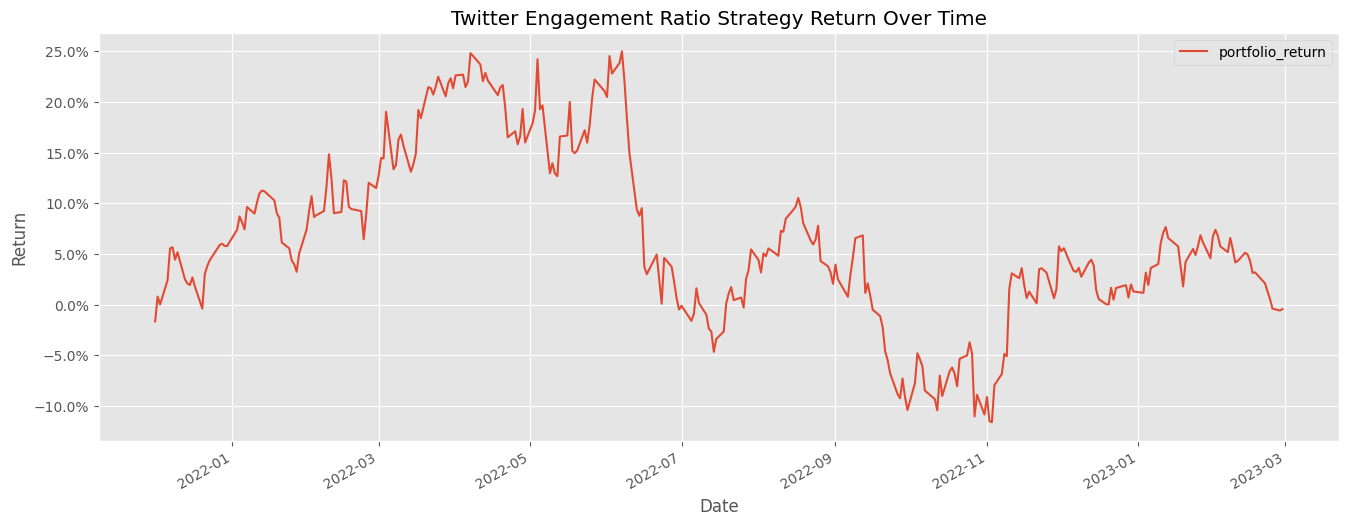

In [16]:
import matplotlib.ticker as mtick

portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title('Twitter Engagement Ratio Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

## Intraday Strategy Using GARCH Model
- Using simulated daily data and intraday 5-min data.
- Load Daily and 5-minute data.
- Define function to fit GARCH model on the daily data and predict 1-day ahead volatility in a rolling window.
- Calculate prediction premium and form a daily signal from it.
- Merge with intraday data and calculate intraday indicators to form the intraday signal.
- Generate the position entry and hold until the end of the day.
- Calculate final strategy returns.

### 1. Load Simulated Daily and Simulated 5-minute data.
- We are loading both datasets, set the indexes and calculate daily log returns.

In [21]:
%pip install arch

import matplotlib.pyplot as plt
from arch import arch_model
import pandas_ta
import pandas as pd
import numpy as np
import os

#data_folder = 'C:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1'

daily_df = pd.read_csv('simulated_daily_data.csv')

daily_df = daily_df.drop('Unnamed: 7', axis=1)

daily_df['Date'] = pd.to_datetime(daily_df['Date'])

daily_df = daily_df.set_index('Date')


intraday_5min_df = pd.read_csv('simulated_5min_data.csv')

intraday_5min_df = intraday_5min_df.drop('Unnamed: 6', axis=1)

intraday_5min_df['datetime'] = pd.to_datetime(intraday_5min_df['datetime'])

intraday_5min_df = intraday_5min_df.set_index('datetime')

intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df.index.date)

intraday_5min_df

Note: you may need to restart the kernel to use updated packages.


open         low        high       close  volume  \
datetime                                                                      
2021-09-29 20:00:00  10379.7775  10364.5950  10398.7025  10370.9575      46   
2021-09-29 20:05:00  10370.9425  10352.4175  10380.2500  10371.1450      53   
2021-09-29 20:10:00  10372.8150  10357.8250  10388.7500  10384.3125     116   
2021-09-29 20:15:00  10385.8275  10384.0825  10457.2000  10442.5175     266   
2021-09-29 20:20:00  10442.5225  10426.2375  10448.0000  10440.9950      65   
...                         ...         ...         ...         ...     ...   
2023-09-20 10:40:00   6792.1025   6783.6000   6796.2500   6790.1375      41   
2023-09-20 10:45:00   6790.5575   6779.1000   6795.7500   6781.9175      42   
2023-09-20 10:50:00   6781.5475   6779.3750   6790.2500   6783.9050      44   
2023-09-20 10:55:00   6783.9025   6779.9000   6793.2500   6782.0900      95   
2023-09-20 11:00:00   6783.7750   6774.3500   6787.5000   6778.6375      54   

                          date  
datetime                        
2021-09-29 20:00:00 2021-09-29  
2021-09-29 20:05:00 2021-09-29  
2021-09-29 20:10:00 2021-09-29  
2021-09-29 20:15:00 2021-09-29  
2021-09-29 20:20:00 2021-09-29  
...                        ...  
2023-09-20 10:40:00 2023-09-20  
2023-09-20 10:45:00 2023-09-20  
2023-09-20 10:50:00 2023-09-20  
2023-09-20 10:55:00 2023-09-20  
2023-09-20 11:00:00 2023-09-20  

[177877 rows x 6 columns]

### 2. Define function to fit GARCH model and predict 1-day ahead volatility in a rolling window.
- We are first calculating the 6-month rolling variance and then we are creating a function in a 6-month rolling - window to fit a garch model and predict the next day variance.

In [22]:
daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()

daily_df['variance'] = daily_df['log_ret'].rolling(180).var()

daily_df = daily_df['2020':]

def predict_volatility(x):
    
    best_model = arch_model(y=x,
                            p=1,
                            q=3).fit(update_freq=5,
                                     disp='off')
    
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1,0]

    print(x.index[-1])
    
    return variance_forecast

daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x: predict_volatility(x))

daily_df = daily_df.dropna()

daily_df

c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002459. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002459. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2020-06-28 00:00:00
2020-06-29 00:00:00
2020-06-30 00:00:00
2020-07-01 00:00:00
2020-07-02 00:00:00
2020-07-03 00:00:00
2020-07-04 00:00:00
2020-07-05 00:00:00
2020-07-06 00:00:00
2020-07-07 00:00:00
2020-07-08 00:00:00
2020-07-09 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002413. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002413. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2020-07-10 00:00:00
2020-07-11 00:00:00
2020-07-12 00:00:00
2020-07-13 00:00:00
2020-07-14 00:00:00
2020-07-15 00:00:00
2020-07-16 00:00:00
2020-07-17 00:00:00
2020-07-18 00:00:00
2020-07-19 00:00:00
2020-07-20 00:00:00
2020-07-21 00:00:00
2020-07-22 00:00:00
2020-07-23 00:00:00
2020-07-24 00:00:00
2020-07-17 00:00:00
2020-07-18 00:00:00
2020-07-19 00:00:00
2020-07-20 00:00:00
2020-07-21 00:00:00
2020-07-22 00:00:00
2020-07-23 00:00:00
2020-07-24 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002369. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(

2020-07-25 00:00:00
2020-07-26 00:00:00
2020-07-27 00:00:00
2020-07-28 00:00:00
2020-07-29 00:00:00
2020-07-30 00:00:00
2020-07-31 00:00:00
2020-08-01 00:00:00
2020-08-02 00:00:00
2020-08-03 00:00:00
2020-08-04 00:00:00
2020-08-05 00:00:00
2020-08-06 00:00:00
2020-08-07 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002424. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
esti

2020-08-08 00:00:00
2020-08-09 00:00:00
2020-08-10 00:00:00
2020-08-11 00:00:00
2020-08-12 00:00:00
2020-08-13 00:00:00
2020-08-14 00:00:00
2020-08-15 00:00:00
2020-08-16 00:00:00
2020-08-17 00:00:00
2020-08-18 00:00:00
2020-08-19 00:00:00
2020-08-20 00:00:00
2020-08-21 00:00:00
2020-08-22 00:00:00
2020-08-23 00:00:00
2020-08-24 00:00:00
2020-08-25 00:00:00
2020-08-26 00:00:00
2020-08-27 00:00:00
2020-08-28 00:00:00
2020-08-29 00:00:00
2020-08-30 00:00:00
2020-08-31 00:00:00
2020-09-01 00:00:00
2020-09-02 00:00:00
2020-09-03 00:00:00
2020-09-04 00:00:00
2020-09-05 00:00:00
2020-09-06 00:00:00
2020-09-07 00:00:00
2020-09-08 00:00:00
2020-09-09 00:00:00
2020-09-10 00:00:00
2020-09-11 00:00:00
2020-09-12 00:00:00
2020-09-13 00:00:00
2020-09-14 00:00:00
2020-09-15 00:00:00
2020-09-16 00:00:00
2020-09-17 00:00:00
2020-09-18 00:00:00
2020-09-19 00:00:00
2020-09-20 00:00:00
2020-09-21 00:00:00
2020-09-01 00:00:00
2020-09-02 00:00:00
2020-09-03 00:00:00
2020-09-04 00:00:00
2020-09-05 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002389. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002452. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2020-09-22 00:00:00
2020-09-23 00:00:00
2020-09-24 00:00:00
2020-09-25 00:00:00
2020-09-26 00:00:00
2020-09-27 00:00:00
2020-09-28 00:00:00
2020-09-29 00:00:00
2020-09-30 00:00:00
2020-10-01 00:00:00
2020-10-02 00:00:00
2020-10-03 00:00:00
2020-10-04 00:00:00
2020-10-05 00:00:00
2020-10-06 00:00:00
2020-10-07 00:00:00
2020-10-08 00:00:00
2020-10-09 00:00:00
2020-10-10 00:00:00
2020-10-11 00:00:00
2020-10-12 00:00:00
2020-10-13 00:00:00
2020-10-14 00:00:00
2020-10-15 00:00:00
2020-10-16 00:00:00
2020-10-17 00:00:00
2020-10-18 00:00:00
2020-10-19 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008508. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000834. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.w

2020-10-20 00:00:00
2020-10-21 00:00:00
2020-10-22 00:00:00
2020-10-23 00:00:00
2020-10-24 00:00:00
2020-10-25 00:00:00
2020-10-26 00:00:00
2020-10-27 00:00:00
2020-10-28 00:00:00
2020-10-29 00:00:00
2020-10-30 00:00:00
2020-10-31 00:00:00
2020-11-01 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007206. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007209. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2020-11-02 00:00:00
2020-11-03 00:00:00
2020-11-04 00:00:00
2020-11-05 00:00:00
2020-11-06 00:00:00
2020-11-07 00:00:00
2020-11-08 00:00:00
2020-11-09 00:00:00
2020-11-10 00:00:00
2020-11-11 00:00:00
2020-11-12 00:00:00
2020-11-13 00:00:00
2020-11-14 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006293. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006751. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2020-11-15 00:00:00
2020-11-16 00:00:00
2020-11-17 00:00:00
2020-11-18 00:00:00
2020-11-19 00:00:00
2020-11-20 00:00:00
2020-11-21 00:00:00
2020-11-22 00:00:00
2020-11-23 00:00:00
2020-11-24 00:00:00
2020-11-25 00:00:00
2020-11-26 00:00:00
2020-11-27 00:00:00
2020-11-28 00:00:00
2020-11-29 00:00:00
2020-11-30 00:00:00
2020-12-01 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006236. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006235. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2020-12-02 00:00:00
2020-12-03 00:00:00
2020-12-04 00:00:00
2020-12-05 00:00:00
2020-12-06 00:00:00
2020-12-07 00:00:00
2020-12-08 00:00:00
2020-12-09 00:00:00
2020-12-10 00:00:00
2020-12-11 00:00:00
2020-12-12 00:00:00
2020-12-13 00:00:00
2020-12-14 00:00:00
2020-12-15 00:00:00
2020-12-16 00:00:00
2020-12-17 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000652. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006619. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.w

2020-12-18 00:00:00
2020-12-19 00:00:00
2020-12-20 00:00:00
2020-12-21 00:00:00
2020-12-22 00:00:00
2020-12-23 00:00:00
2020-12-24 00:00:00
2020-12-25 00:00:00
2020-12-26 00:00:00
2020-12-27 00:00:00
2020-12-28 00:00:00
2020-12-29 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007816. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007816. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2020-12-30 00:00:00
2020-12-31 00:00:00
2021-01-01 00:00:00
2021-01-02 00:00:00
2021-01-03 00:00:00
2021-01-04 00:00:00
2021-01-05 00:00:00
2021-01-06 00:00:00
2021-01-07 00:00:00
2021-01-08 00:00:00
2021-01-09 00:00:00
2021-01-10 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009561. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model para

2021-01-11 00:00:00
2021-01-12 00:00:00
2021-01-13 00:00:00
2021-01-14 00:00:00
2021-01-15 00:00:00
2021-01-16 00:00:00
2021-01-17 00:00:00
2021-01-18 00:00:00
2021-01-19 00:00:00
2021-01-20 00:00:00
2021-01-21 00:00:00
2021-01-22 00:00:00
2021-01-23 00:00:00
2021-01-24 00:00:00
2021-01-25 00:00:00
2021-01-26 00:00:00
2021-01-27 00:00:00
2021-01-28 00:00:00
2021-01-29 00:00:00
2021-01-30 00:00:00
2021-01-31 00:00:00
2021-02-01 00:00:00
2021-02-02 00:00:00
2021-02-03 00:00:00
2021-02-04 00:00:00
2021-02-05 00:00:00
2021-02-06 00:00:00
2021-02-07 00:00:00
2021-02-08 00:00:00
2021-02-09 00:00:00
2021-02-10 00:00:00
2021-01-27 00:00:00
2021-01-28 00:00:00
2021-01-29 00:00:00
2021-01-30 00:00:00
2021-01-31 00:00:00
2021-02-01 00:00:00
2021-02-02 00:00:00
2021-02-03 00:00:00
2021-02-04 00:00:00
2021-02-05 00:00:00
2021-02-06 00:00:00
2021-02-07 00:00:00
2021-02-08 00:00:00
2021-02-09 00:00:00
2021-02-10 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001207. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001184. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2021-02-11 00:00:00
2021-02-12 00:00:00
2021-02-13 00:00:00
2021-02-14 00:00:00
2021-02-15 00:00:00
2021-02-16 00:00:00
2021-02-17 00:00:00
2021-02-18 00:00:00
2021-02-19 00:00:00
2021-02-20 00:00:00
2021-02-21 00:00:00
2021-02-22 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001382. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00138. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(

2021-02-23 00:00:00
2021-02-24 00:00:00
2021-02-25 00:00:00
2021-02-26 00:00:00
2021-02-27 00:00:00
2021-02-28 00:00:00
2021-03-01 00:00:00
2021-03-02 00:00:00
2021-03-03 00:00:00
2021-03-04 00:00:00
2021-03-05 00:00:00
2021-03-06 00:00:00
2021-03-07 00:00:00
2021-03-08 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001501. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001522. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2021-03-09 00:00:00
2021-03-10 00:00:00
2021-03-11 00:00:00
2021-03-12 00:00:00
2021-03-13 00:00:00
2021-03-14 00:00:00
2021-03-15 00:00:00
2021-03-16 00:00:00
2021-03-17 00:00:00
2021-03-18 00:00:00
2021-03-19 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001505. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001507. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2021-03-20 00:00:00
2021-03-21 00:00:00
2021-03-22 00:00:00
2021-03-23 00:00:00
2021-03-24 00:00:00
2021-03-25 00:00:00
2021-03-26 00:00:00
2021-03-27 00:00:00
2021-03-28 00:00:00
2021-03-29 00:00:00
2021-03-30 00:00:00
2021-03-31 00:00:00
2021-04-01 00:00:00
2021-04-02 00:00:00
2021-04-03 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001547. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001562. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2021-04-04 00:00:00
2021-04-05 00:00:00
2021-04-06 00:00:00
2021-04-07 00:00:00
2021-04-08 00:00:00
2021-04-09 00:00:00
2021-04-10 00:00:00
2021-04-11 00:00:00
2021-04-12 00:00:00
2021-04-13 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001587. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001589. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2021-04-14 00:00:00
2021-04-15 00:00:00
2021-04-16 00:00:00
2021-04-17 00:00:00
2021-04-18 00:00:00
2021-04-19 00:00:00
2021-04-20 00:00:00
2021-04-21 00:00:00
2021-04-22 00:00:00
2021-04-23 00:00:00
2021-04-24 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001618. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001625. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2021-04-25 00:00:00
2021-04-26 00:00:00
2021-04-27 00:00:00
2021-04-28 00:00:00
2021-04-29 00:00:00
2021-04-30 00:00:00
2021-05-01 00:00:00
2021-05-02 00:00:00
2021-05-03 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001716. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001716. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2021-05-04 00:00:00
2021-05-05 00:00:00
2021-05-06 00:00:00
2021-05-07 00:00:00
2021-05-08 00:00:00
2021-05-09 00:00:00
2021-05-10 00:00:00
2021-05-11 00:00:00
2021-05-12 00:00:00
2021-05-13 00:00:00
2021-05-14 00:00:00
2021-05-15 00:00:00
2021-05-16 00:00:00
2021-05-17 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001759. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001745. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2021-05-18 00:00:00
2021-05-19 00:00:00
2021-05-20 00:00:00
2021-05-21 00:00:00
2021-05-22 00:00:00
2021-05-23 00:00:00
2021-05-24 00:00:00
2021-05-25 00:00:00
2021-05-26 00:00:00
2021-05-27 00:00:00
2021-05-28 00:00:00
2021-05-29 00:00:00
2021-05-30 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002023. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002072. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2021-05-31 00:00:00
2021-06-01 00:00:00
2021-06-02 00:00:00
2021-06-03 00:00:00
2021-06-04 00:00:00
2021-06-05 00:00:00
2021-06-06 00:00:00
2021-06-07 00:00:00
2021-06-08 00:00:00
2021-06-09 00:00:00
2021-06-10 00:00:00
2021-06-11 00:00:00
2021-06-12 00:00:00
2021-06-13 00:00:00
2021-06-14 00:00:00
2021-06-15 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002167. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002159. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2021-06-16 00:00:00
2021-06-17 00:00:00
2021-06-18 00:00:00
2021-06-19 00:00:00
2021-06-20 00:00:00
2021-06-21 00:00:00
2021-06-22 00:00:00
2021-06-23 00:00:00
2021-06-24 00:00:00
2021-06-25 00:00:00
2021-06-26 00:00:00
2021-06-27 00:00:00
2021-06-28 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002273. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002294. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2021-06-29 00:00:00
2021-06-30 00:00:00
2021-07-01 00:00:00
2021-07-02 00:00:00
2021-07-03 00:00:00
2021-07-04 00:00:00
2021-07-05 00:00:00
2021-07-06 00:00:00
2021-07-07 00:00:00
2021-07-08 00:00:00
2021-07-09 00:00:00
2021-07-10 00:00:00
2021-07-11 00:00:00
2021-07-12 00:00:00
2021-07-13 00:00:00
2021-07-14 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002406. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002373. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2021-07-15 00:00:00
2021-07-16 00:00:00
2021-07-17 00:00:00
2021-07-18 00:00:00
2021-07-19 00:00:00
2021-07-20 00:00:00
2021-07-21 00:00:00
2021-07-22 00:00:00
2021-07-23 00:00:00
2021-07-24 00:00:00
2021-07-25 00:00:00
2021-07-26 00:00:00
2021-07-27 00:00:00
2021-07-28 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002176. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2021-07-29 00:00:00
2021-07-30 00:00:00
2021-07-31 00:00:00
2021-08-01 00:00:00
2021-08-02 00:00:00
2021-08-03 00:00:00
2021-08-04 00:00:00
2021-08-05 00:00:00
2021-08-06 00:00:00
2021-08-07 00:00:00
2021-08-08 00:00:00
2021-08-09 00:00:00
2021-08-10 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002049. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002049. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2021-08-11 00:00:00
2021-08-12 00:00:00
2021-08-13 00:00:00
2021-08-14 00:00:00
2021-08-15 00:00:00
2021-08-16 00:00:00
2021-08-17 00:00:00
2021-08-18 00:00:00
2021-08-19 00:00:00
2021-08-20 00:00:00
2021-08-21 00:00:00
2021-08-22 00:00:00
2021-08-23 00:00:00
2021-08-24 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001884. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001908. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2021-08-25 00:00:00
2021-08-26 00:00:00
2021-08-27 00:00:00
2021-08-28 00:00:00
2021-08-29 00:00:00
2021-08-30 00:00:00
2021-08-31 00:00:00
2021-09-01 00:00:00
2021-09-02 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001803. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001811. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2021-09-03 00:00:00
2021-09-04 00:00:00
2021-09-05 00:00:00
2021-09-06 00:00:00
2021-09-07 00:00:00
2021-09-08 00:00:00
2021-09-09 00:00:00
2021-09-10 00:00:00
2021-09-11 00:00:00
2021-09-12 00:00:00
2021-09-13 00:00:00
2021-09-14 00:00:00
2021-09-15 00:00:00
2021-09-16 00:00:00
2021-09-17 00:00:00
2021-09-18 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001734. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001733. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2021-09-19 00:00:00
2021-09-20 00:00:00
2021-09-21 00:00:00
2021-09-22 00:00:00
2021-09-23 00:00:00
2021-09-24 00:00:00
2021-09-25 00:00:00
2021-09-26 00:00:00
2021-09-27 00:00:00
2021-09-28 00:00:00
2021-09-29 00:00:00
2021-09-30 00:00:00
2021-10-01 00:00:00
2021-10-02 00:00:00
2021-10-03 00:00:00
2021-10-04 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001805. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001817. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2021-10-05 00:00:00
2021-10-06 00:00:00
2021-10-07 00:00:00
2021-10-08 00:00:00
2021-10-09 00:00:00
2021-10-10 00:00:00
2021-10-11 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001923. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001923. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2021-10-12 00:00:00
2021-10-13 00:00:00
2021-10-14 00:00:00
2021-10-15 00:00:00
2021-10-16 00:00:00
2021-10-17 00:00:00
2021-10-18 00:00:00
2021-10-19 00:00:00
2021-10-20 00:00:00
2021-10-21 00:00:00
2021-10-22 00:00:00
2021-10-23 00:00:00
2021-10-24 00:00:00
2021-10-25 00:00:00
2021-10-26 00:00:00
2021-10-27 00:00:00
2021-10-28 00:00:00
2021-10-29 00:00:00
2021-10-30 00:00:00
2021-10-31 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001921. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00192. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(

2021-11-01 00:00:00
2021-11-02 00:00:00
2021-11-03 00:00:00
2021-11-04 00:00:00
2021-11-05 00:00:00
2021-11-06 00:00:00
2021-11-07 00:00:00
2021-11-08 00:00:00
2021-11-09 00:00:00
2021-11-10 00:00:00
2021-11-11 00:00:00
2021-11-12 00:00:00
2021-11-13 00:00:00
2021-11-14 00:00:00
2021-11-15 00:00:00
2021-11-16 00:00:00
2021-11-17 00:00:00
2021-11-18 00:00:00
2021-11-19 00:00:00
2021-11-20 00:00:00
2021-11-21 00:00:00
2021-11-22 00:00:00
2021-11-23 00:00:00
2021-11-24 00:00:00
2021-11-25 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001398. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00139. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(

2021-11-26 00:00:00
2021-11-27 00:00:00
2021-11-28 00:00:00
2021-11-29 00:00:00
2021-11-30 00:00:00
2021-12-01 00:00:00
2021-12-02 00:00:00
2021-12-03 00:00:00
2021-12-04 00:00:00
2021-12-05 00:00:00
2021-12-06 00:00:00
2021-12-07 00:00:00
2021-12-08 00:00:00
2021-12-09 00:00:00
2021-12-10 00:00:00
2021-12-11 00:00:00
2021-12-12 00:00:00
2021-12-13 00:00:00
2021-12-14 00:00:00
2021-12-15 00:00:00
2021-12-16 00:00:00
2021-12-17 00:00:00
2021-12-18 00:00:00
2021-12-19 00:00:00
2021-12-20 00:00:00
2021-12-21 00:00:00
2021-12-22 00:00:00
2021-12-23 00:00:00
2021-12-24 00:00:00
2021-12-25 00:00:00
2021-12-26 00:00:00
2021-12-27 00:00:00
2021-12-28 00:00:00
2021-12-29 00:00:00
2021-12-12 00:00:00
2021-12-13 00:00:00
2021-12-14 00:00:00
2021-12-15 00:00:00
2021-12-16 00:00:00
2021-12-17 00:00:00
2021-12-18 00:00:00
2021-12-19 00:00:00
2021-12-20 00:00:00
2021-12-21 00:00:00
2021-12-22 00:00:00
2021-12-23 00:00:00
2021-12-24 00:00:00
2021-12-25 00:00:00
2021-12-26 00:00:00
2021-12-27 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001303. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001302. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2021-12-30 00:00:00
2021-12-31 00:00:00
2022-01-01 00:00:00
2022-01-02 00:00:00
2022-01-03 00:00:00
2022-01-04 00:00:00
2022-01-05 00:00:00
2022-01-06 00:00:00
2022-01-07 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001152. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001144. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-01-08 00:00:00
2022-01-09 00:00:00
2022-01-10 00:00:00
2022-01-11 00:00:00
2022-01-12 00:00:00
2022-01-13 00:00:00
2022-01-14 00:00:00
2022-01-15 00:00:00
2022-01-16 00:00:00
2022-01-17 00:00:00
2022-01-18 00:00:00
2022-01-19 00:00:00
2022-01-20 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001152. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001152. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-01-21 00:00:00
2022-01-22 00:00:00
2022-01-23 00:00:00
2022-01-24 00:00:00
2022-01-25 00:00:00
2022-01-26 00:00:00
2022-01-27 00:00:00
2022-01-28 00:00:00
2022-01-29 00:00:00
2022-01-30 00:00:00
2022-01-31 00:00:00
2022-02-01 00:00:00
2022-02-02 00:00:00
2022-02-03 00:00:00
2022-02-04 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001168. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001159. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-02-05 00:00:00
2022-02-06 00:00:00
2022-02-07 00:00:00
2022-02-08 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001158. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001164. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-02-09 00:00:00
2022-02-10 00:00:00
2022-02-11 00:00:00
2022-02-12 00:00:00
2022-02-13 00:00:00
2022-02-14 00:00:00
2022-02-15 00:00:00
2022-02-16 00:00:00
2022-02-17 00:00:00
2022-02-18 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001131. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001135. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-02-19 00:00:00
2022-02-20 00:00:00
2022-02-21 00:00:00
2022-02-22 00:00:00
2022-02-23 00:00:00
2022-02-24 00:00:00
2022-02-25 00:00:00
2022-02-26 00:00:00
2022-02-27 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001152. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001155. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-02-28 00:00:00
2022-03-01 00:00:00
2022-03-02 00:00:00
2022-03-03 00:00:00
2022-03-04 00:00:00
2022-03-05 00:00:00
2022-03-06 00:00:00
2022-03-07 00:00:00
2022-03-08 00:00:00
2022-03-09 00:00:00
2022-03-10 00:00:00
2022-03-11 00:00:00
2022-03-12 00:00:00
2022-03-13 00:00:00
2022-03-14 00:00:00
2022-03-15 00:00:00
2022-03-16 00:00:00
2022-03-17 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001251. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001251. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-03-18 00:00:00
2022-03-19 00:00:00
2022-03-20 00:00:00
2022-03-21 00:00:00
2022-03-22 00:00:00
2022-03-23 00:00:00
2022-03-24 00:00:00
2022-03-25 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001218. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001206. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-03-26 00:00:00
2022-03-27 00:00:00
2022-03-28 00:00:00
2022-03-29 00:00:00
2022-03-30 00:00:00
2022-03-31 00:00:00
2022-04-01 00:00:00
2022-04-02 00:00:00
2022-04-03 00:00:00
2022-04-04 00:00:00
2022-04-05 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001179. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001178. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-04-06 00:00:00
2022-04-07 00:00:00
2022-04-08 00:00:00
2022-04-09 00:00:00
2022-04-10 00:00:00
2022-04-11 00:00:00
2022-04-12 00:00:00
2022-04-13 00:00:00
2022-04-14 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00109. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001094. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(

2022-04-15 00:00:00
2022-04-16 00:00:00
2022-04-17 00:00:00
2022-04-18 00:00:00
2022-04-19 00:00:00
2022-04-20 00:00:00
2022-04-21 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001077. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001071. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-04-22 00:00:00
2022-04-23 00:00:00
2022-04-24 00:00:00
2022-04-25 00:00:00
2022-04-26 00:00:00
2022-04-27 00:00:00
2022-04-28 00:00:00
2022-04-29 00:00:00
2022-04-30 00:00:00
2022-05-01 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001047. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001038. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-05-02 00:00:00
2022-05-03 00:00:00
2022-05-04 00:00:00
2022-05-05 00:00:00
2022-05-06 00:00:00
2022-05-07 00:00:00
2022-05-08 00:00:00
2022-05-09 00:00:00
2022-05-10 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001065. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0011. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


2022-05-11 00:00:00
2022-05-12 00:00:00
2022-05-13 00:00:00
2022-05-14 00:00:00
2022-05-15 00:00:00
2022-05-16 00:00:00
2022-05-17 00:00:00
2022-05-18 00:00:00
2022-05-19 00:00:00
2022-05-20 00:00:00
2022-05-21 00:00:00
2022-05-22 00:00:00
2022-05-23 00:00:00
2022-05-24 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001172. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001171. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-05-25 00:00:00
2022-05-26 00:00:00
2022-05-27 00:00:00
2022-05-28 00:00:00
2022-05-29 00:00:00
2022-05-30 00:00:00
2022-05-31 00:00:00
2022-06-01 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001172. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001162. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-06-02 00:00:00
2022-06-03 00:00:00
2022-06-04 00:00:00
2022-06-05 00:00:00
2022-06-06 00:00:00
2022-06-07 00:00:00
2022-06-08 00:00:00
2022-06-09 00:00:00
2022-06-10 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00117. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(

2022-06-11 00:00:00
2022-06-12 00:00:00
2022-06-13 00:00:00
2022-06-14 00:00:00
2022-06-15 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001158. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001305. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-06-16 00:00:00
2022-06-17 00:00:00
2022-06-18 00:00:00
2022-06-19 00:00:00
2022-06-20 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001352. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001378. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-06-21 00:00:00
2022-06-22 00:00:00
2022-06-23 00:00:00
2022-06-24 00:00:00
2022-06-25 00:00:00
2022-06-26 00:00:00
2022-06-27 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001396. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001415. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-06-28 00:00:00
2022-06-29 00:00:00
2022-06-30 00:00:00
2022-07-01 00:00:00
2022-07-02 00:00:00
2022-07-03 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001397. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
esti

2022-07-04 00:00:00
2022-07-05 00:00:00
2022-07-06 00:00:00
2022-07-07 00:00:00
2022-07-08 00:00:00
2022-07-09 00:00:00
2022-07-10 00:00:00
2022-07-11 00:00:00
2022-07-12 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001395. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001391. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-07-13 00:00:00
2022-07-14 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001428. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001429. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-07-15 00:00:00
2022-07-16 00:00:00
2022-07-17 00:00:00
2022-07-18 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00143. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001431. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(

2022-07-19 00:00:00
2022-07-20 00:00:00
2022-07-21 00:00:00
2022-07-22 00:00:00
2022-07-23 00:00:00
2022-07-24 00:00:00
2022-07-25 00:00:00
2022-07-26 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001412. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001405. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-07-27 00:00:00
2022-07-28 00:00:00
2022-07-29 00:00:00
2022-07-30 00:00:00
2022-07-31 00:00:00
2022-08-01 00:00:00
2022-08-02 00:00:00
2022-08-03 00:00:00
2022-08-04 00:00:00
2022-08-05 00:00:00
2022-08-06 00:00:00
2022-08-07 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001455. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001455. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-08-08 00:00:00
2022-08-09 00:00:00
2022-08-10 00:00:00
2022-08-11 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001374. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001378. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-08-12 00:00:00
2022-08-13 00:00:00
2022-08-14 00:00:00
2022-08-15 00:00:00
2022-08-16 00:00:00
2022-08-17 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00138. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001367. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(

2022-08-18 00:00:00
2022-08-19 00:00:00
2022-08-20 00:00:00
2022-08-21 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001384. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00138. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(

2022-08-22 00:00:00
2022-08-23 00:00:00
2022-08-24 00:00:00
2022-08-25 00:00:00
2022-08-26 00:00:00
2022-08-27 00:00:00
2022-08-28 00:00:00
2022-08-29 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001368. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001364. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-08-30 00:00:00
2022-08-31 00:00:00
2022-09-01 00:00:00
2022-09-02 00:00:00
2022-09-03 00:00:00
2022-09-04 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001241. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001241. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-09-05 00:00:00
2022-09-06 00:00:00
2022-09-07 00:00:00
2022-09-08 00:00:00
2022-09-09 00:00:00
2022-09-10 00:00:00
2022-09-11 00:00:00
2022-09-12 00:00:00
2022-09-13 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00119. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001194. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(

2022-09-14 00:00:00
2022-09-15 00:00:00
2022-09-16 00:00:00
2022-09-17 00:00:00
2022-09-18 00:00:00
2022-09-19 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001278. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001277. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-09-20 00:00:00
2022-09-21 00:00:00
2022-09-22 00:00:00
2022-09-23 00:00:00
2022-09-24 00:00:00
2022-09-25 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001277. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001291. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-09-26 00:00:00
2022-09-27 00:00:00
2022-09-28 00:00:00
2022-09-29 00:00:00
2022-09-30 00:00:00
2022-10-01 00:00:00
2022-10-02 00:00:00
2022-10-03 00:00:00
2022-10-04 00:00:00
2022-10-05 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001273. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001273. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-10-06 00:00:00
2022-10-07 00:00:00
2022-10-08 00:00:00
2022-10-09 00:00:00
2022-10-10 00:00:00
2022-10-11 00:00:00
2022-10-12 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001269. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001248. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-10-13 00:00:00
2022-10-14 00:00:00
2022-10-15 00:00:00
2022-10-16 00:00:00
2022-10-17 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001232. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-10-18 00:00:00
2022-10-19 00:00:00
2022-10-20 00:00:00
2022-10-21 00:00:00
2022-10-22 00:00:00
2022-10-23 00:00:00
2022-10-24 00:00:00
2022-10-25 00:00:00
2022-10-26 00:00:00
2022-10-27 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00123. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00123. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


2022-10-28 00:00:00
2022-10-29 00:00:00
2022-10-30 00:00:00
2022-10-31 00:00:00
2022-11-01 00:00:00
2022-11-02 00:00:00
2022-11-03 00:00:00
2022-11-04 00:00:00
2022-11-05 00:00:00
2022-11-06 00:00:00
2022-11-07 00:00:00
2022-11-08 00:00:00
2022-11-09 00:00:00
2022-11-10 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001218. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001216. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-11-11 00:00:00
2022-11-12 00:00:00
2022-11-13 00:00:00
2022-11-14 00:00:00
2022-11-15 00:00:00
2022-11-16 00:00:00
2022-11-17 00:00:00
2022-11-18 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001298. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001284. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-11-19 00:00:00
2022-11-20 00:00:00
2022-11-21 00:00:00
2022-11-22 00:00:00
2022-11-23 00:00:00
2022-11-24 00:00:00
2022-11-25 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001247. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001252. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-11-26 00:00:00
2022-11-27 00:00:00
2022-11-28 00:00:00
2022-11-29 00:00:00
2022-11-30 00:00:00
2022-12-01 00:00:00
2022-12-02 00:00:00
2022-12-03 00:00:00
2022-12-04 00:00:00
2022-12-05 00:00:00
2022-12-06 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001221. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001201. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-12-07 00:00:00
2022-12-08 00:00:00
2022-12-09 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001188. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001171. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-12-10 00:00:00
2022-12-11 00:00:00
2022-12-12 00:00:00
2022-12-13 00:00:00
2022-12-14 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001006. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001005. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn

2022-12-15 00:00:00
2022-12-16 00:00:00
2022-12-17 00:00:00
2022-12-18 00:00:00
2022-12-19 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009034. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009039. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2022-12-20 00:00:00
2022-12-21 00:00:00
2022-12-22 00:00:00
2022-12-23 00:00:00
2022-12-24 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008867. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008856. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2022-12-25 00:00:00
2022-12-26 00:00:00
2022-12-27 00:00:00
2022-12-28 00:00:00
2022-12-29 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008797. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008792. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2022-12-30 00:00:00
2022-12-31 00:00:00
2023-01-01 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008633. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008634. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-01-02 00:00:00
2023-01-03 00:00:00
2023-01-04 00:00:00
2023-01-05 00:00:00
2023-01-06 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008461. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008467. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-01-07 00:00:00
2023-01-08 00:00:00
2023-01-09 00:00:00
2023-01-10 00:00:00
2023-01-11 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008255. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008141. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-01-12 00:00:00
2023-01-13 00:00:00
2023-01-14 00:00:00
2023-01-15 00:00:00
2023-01-16 00:00:00
2023-01-17 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008442. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008247. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-01-18 00:00:00
2023-01-19 00:00:00
2023-01-20 00:00:00
2023-01-21 00:00:00
2023-01-22 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000819. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008482. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.w

2023-01-23 00:00:00
2023-01-24 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007906. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007931. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-01-25 00:00:00
2023-01-26 00:00:00
2023-01-27 00:00:00
2023-01-28 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000793. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000792. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.wa

2023-01-29 00:00:00
2023-01-30 00:00:00
2023-01-31 00:00:00
2023-02-01 00:00:00
2023-02-02 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008052. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008056. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-02-03 00:00:00
2023-02-04 00:00:00
2023-02-05 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007996. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007969. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-02-06 00:00:00
2023-02-07 00:00:00
2023-02-08 00:00:00
2023-02-09 00:00:00
2023-02-10 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007938. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007929. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-02-11 00:00:00
2023-02-12 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008067. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008038. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-02-13 00:00:00
2023-02-14 00:00:00
2023-02-15 00:00:00
2023-02-16 00:00:00
2023-02-17 00:00:00
2023-02-18 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008057. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007873. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-02-19 00:00:00
2023-02-20 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008003. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008015. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-02-21 00:00:00
2023-02-22 00:00:00
2023-02-23 00:00:00
2023-02-24 00:00:00
2023-02-25 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007787. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007786. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-02-26 00:00:00
2023-02-27 00:00:00
2023-02-28 00:00:00
2023-03-01 00:00:00
2023-03-02 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007726. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007741. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-03-03 00:00:00
2023-03-04 00:00:00
2023-03-05 00:00:00
2023-03-06 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007888. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007743. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-03-07 00:00:00
2023-03-08 00:00:00
2023-03-09 00:00:00
2023-03-10 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007189. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007408. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-03-11 00:00:00
2023-03-12 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007154. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007574. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-03-13 00:00:00
2023-03-14 00:00:00
2023-03-15 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007556. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000757. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.w

2023-03-16 00:00:00
2023-03-17 00:00:00
2023-03-18 00:00:00
2023-03-19 00:00:00
2023-03-20 00:00:00
2023-03-21 00:00:00
2023-03-22 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007954. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007972. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-03-23 00:00:00
2023-03-24 00:00:00
2023-03-25 00:00:00
2023-03-26 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008018. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007996. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-03-27 00:00:00
2023-03-28 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008055. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008125. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-03-29 00:00:00
2023-03-30 00:00:00
2023-03-31 00:00:00
2023-04-01 00:00:00
2023-04-02 00:00:00
2023-04-03 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008131. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008127. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-04-04 00:00:00
2023-04-05 00:00:00
2023-04-06 00:00:00
2023-04-07 00:00:00
2023-04-08 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008007. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008005. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-04-09 00:00:00
2023-04-10 00:00:00
2023-04-11 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008098. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008109. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-04-12 00:00:00
2023-04-13 00:00:00
2023-04-14 00:00:00
2023-04-15 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008099. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008096. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-04-16 00:00:00
2023-04-17 00:00:00
2023-04-18 00:00:00
2023-04-19 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008128. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-04-20 00:00:00
2023-04-21 00:00:00
2023-04-22 00:00:00
2023-04-23 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008433. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000844. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.w

2023-04-24 00:00:00
2023-04-25 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008323. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008313. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-04-26 00:00:00
2023-04-27 00:00:00
2023-04-28 00:00:00
2023-04-29 00:00:00
2023-04-30 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008374. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000837. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.w

2023-05-01 00:00:00
2023-05-02 00:00:00
2023-05-03 00:00:00
2023-05-04 00:00:00
2023-05-05 00:00:00
2023-05-06 00:00:00
2023-05-07 00:00:00
2023-05-08 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008472. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008372. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-05-09 00:00:00
2023-05-10 00:00:00
2023-05-11 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005826. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005847. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-05-12 00:00:00
2023-05-13 00:00:00
2023-05-14 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005794. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005785. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-05-15 00:00:00
2023-05-16 00:00:00
2023-05-17 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005778. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005784. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-05-18 00:00:00
2023-05-19 00:00:00
2023-05-20 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005771. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005707. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-05-21 00:00:00
2023-05-22 00:00:00
2023-05-23 00:00:00
2023-05-24 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005667. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005673. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-05-25 00:00:00
2023-05-26 00:00:00
2023-05-27 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005741. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005726. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-05-28 00:00:00
2023-05-29 00:00:00
2023-05-30 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005737. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005727. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-05-31 00:00:00
2023-06-01 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005755. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005759. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-06-02 00:00:00
2023-06-03 00:00:00
2023-06-04 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005756. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005755. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-06-05 00:00:00
2023-06-06 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006036. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006104. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-06-07 00:00:00
2023-06-08 00:00:00
2023-06-09 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006104. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006104. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-06-10 00:00:00
2023-06-11 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000609. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000609. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.wa

2023-06-12 00:00:00
2023-06-13 00:00:00
2023-06-14 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006048. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.war

2023-06-15 00:00:00
2023-06-16 00:00:00
2023-06-17 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006049. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006023. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-06-18 00:00:00
2023-06-19 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006005. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006148. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-06-20 00:00:00
2023-06-21 00:00:00
2023-06-22 00:00:00
2023-06-23 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006316. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006318. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-06-24 00:00:00
2023-06-25 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006338. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006334. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-06-26 00:00:00
2023-06-27 00:00:00
2023-06-28 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006368. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006369. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-06-29 00:00:00
2023-06-30 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000637. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000637. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.wa

2023-07-01 00:00:00
2023-07-02 00:00:00
2023-07-03 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006369. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006377. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-07-04 00:00:00
2023-07-05 00:00:00
2023-07-06 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006396. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006426. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-07-07 00:00:00
2023-07-08 00:00:00
2023-07-09 00:00:00
2023-07-10 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006432. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006428. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-07-11 00:00:00
2023-07-12 00:00:00
2023-07-13 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006129. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000605. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.w

2023-07-14 00:00:00
2023-07-15 00:00:00
2023-07-16 00:00:00
2023-07-17 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006125. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006126. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-07-18 00:00:00
2023-07-19 00:00:00
2023-07-20 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005806. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005807. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-07-21 00:00:00
2023-07-22 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005805. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005797. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-07-23 00:00:00
2023-07-24 00:00:00
2023-07-25 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005833. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005832. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-07-26 00:00:00
2023-07-27 00:00:00
2023-07-28 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005834. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005782. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-07-29 00:00:00
2023-07-30 00:00:00
2023-07-31 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005681. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000565. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.w

2023-08-01 00:00:00
2023-08-02 00:00:00
2023-08-03 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005673. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005671. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-08-04 00:00:00
2023-08-05 00:00:00
2023-08-06 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000565. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005626. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.w

2023-08-07 00:00:00
2023-08-08 00:00:00
2023-08-09 00:00:00
2023-08-10 00:00:00
2023-08-11 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005484. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005484. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-08-12 00:00:00
2023-08-13 00:00:00
2023-08-14 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005466. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005032. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-08-15 00:00:00
2023-08-16 00:00:00
2023-08-17 00:00:00
2023-08-18 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004924. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000523. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.w

2023-08-19 00:00:00
2023-08-20 00:00:00
2023-08-21 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005215. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005209. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-08-22 00:00:00
2023-08-23 00:00:00
2023-08-24 00:00:00
2023-08-25 00:00:00
2023-08-26 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005158. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005164. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-08-27 00:00:00
2023-08-28 00:00:00
2023-08-29 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005112. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005306. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-08-30 00:00:00
2023-08-31 00:00:00
2023-09-01 00:00:00
2023-09-02 00:00:00
2023-09-03 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005336. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005338. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-09-04 00:00:00
2023-09-05 00:00:00
2023-09-06 00:00:00
2023-09-07 00:00:00
2023-09-08 00:00:00
2023-09-09 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005066. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000506. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.w

2023-09-10 00:00:00
2023-09-11 00:00:00
2023-09-12 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004366. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004362. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-09-13 00:00:00
2023-09-14 00:00:00
2023-09-15 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003913. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003828. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

2023-09-16 00:00:00
2023-09-17 00:00:00
2023-09-18 00:00:00


c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003811. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\ASUS\Desktop\Juanes\Infraestructura\Proyecto-test1\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003761. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.

Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-06-28  2262.115234  2299.386719  2243.881348  2285.895508  2285.895508   
2020-06-29  2285.007324  2309.393311  2260.468994  2297.713623  2297.713623   
2020-06-30  2296.395264  2304.458984  2271.209473  2284.498291  2284.498291   
2020-07-01  2286.496338  2327.438721  2276.183838  2307.081299  2307.081299   
2020-07-02  2307.784912  2318.740723  2259.155762  2280.852539  2280.852539   
...                 ...          ...          ...          ...          ...   
2023-09-14  6557.069336  6693.655762  6542.862793  6634.918457  6634.918457   
2023-09-15  6633.454590  6710.124512  6560.175293  6652.173340  6652.173340   
2023-09-16  6651.549805  6688.692383  6618.472656  6642.070313  6642.070313   
2023-09-17  6641.981934  6654.499512  6611.268555  6633.546875  6633.546875   
2023-09-18  6633.248535  6853.683594  6603.878906  6688.570313  6688.570313   

                  Volume   log_ret  variance  predictions  
Date                                                       
2020-06-28  1.456087e+10  0.010797  0.002473     0.000728  
2020-06-29  1.646055e+10  0.005157  0.002473     0.000651  
2020-06-30  1.573580e+10 -0.005768  0.002468     0.000877  
2020-07-01  1.597155e+10  0.009837  0.002455     0.000618  
2020-07-02  1.633892e+10 -0.011434  0.002456     0.000703  
...                  ...       ...       ...          ...  
2023-09-14  1.381136e+10  0.011801  0.000393     0.000334  
2023-09-15  1.147974e+10  0.002597  0.000385     0.000292  
2023-09-16  7.402031e+09 -0.001520  0.000384     0.000286  
2023-09-17  6.774211e+09 -0.001284  0.000383     0.000280  
2023-09-18  1.561534e+10  0.008261  0.000378     0.000298  

[1178 rows x 9 columns]

### 3. Calculate prediction premium and form a daily signal from it.
- We are calculating the prediction premium. And calculate its 6-month rolling standard deviation.

- From this we are creating our daily signal.

In [23]:
daily_df['prediction_premium'] = (daily_df['predictions']-daily_df['variance'])/daily_df['variance']

daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()

daily_df['signal_daily'] = daily_df.apply(lambda x: 1 if (x['prediction_premium']>x['premium_std'])
                                         else (-1 if (x['prediction_premium']<x['premium_std']*-1) else np.nan),
                                         axis=1)

daily_df['signal_daily'] = daily_df['signal_daily'].shift()

daily_df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-06-28  2262.115234  2299.386719  2243.881348  2285.895508  2285.895508   
2020-06-29  2285.007324  2309.393311  2260.468994  2297.713623  2297.713623   
2020-06-30  2296.395264  2304.458984  2271.209473  2284.498291  2284.498291   
2020-07-01  2286.496338  2327.438721  2276.183838  2307.081299  2307.081299   
2020-07-02  2307.784912  2318.740723  2259.155762  2280.852539  2280.852539   
...                 ...          ...          ...          ...          ...   
2023-09-14  6557.069336  6693.655762  6542.862793  6634.918457  6634.918457   
2023-09-15  6633.454590  6710.124512  6560.175293  6652.173340  6652.173340   
2023-09-16  6651.549805  6688.692383  6618.472656  6642.070313  6642.070313   
2023-09-17  6641.981934  6654.499512  6611.268555  6633.546875  6633.546875   
2023-09-18  6633.248535  6853.683594  6603.878906  6688.570313  6688.570313   

                  Volume   log_ret  variance  predictions  prediction_premium  \
Date                                                                            
2020-06-28  1.456087e+10  0.010797  0.002473     0.000728           -0.705556   
2020-06-29  1.646055e+10  0.005157  0.002473     0.000651           -0.736678   
2020-06-30  1.573580e+10 -0.005768  0.002468     0.000877           -0.644670   
2020-07-01  1.597155e+10  0.009837  0.002455     0.000618           -0.748362   
2020-07-02  1.633892e+10 -0.011434  0.002456     0.000703           -0.713818   
...                  ...       ...       ...          ...                 ...   
2023-09-14  1.381136e+10  0.011801  0.000393     0.000334           -0.151792   
2023-09-15  1.147974e+10  0.002597  0.000385     0.000292           -0.240810   
2023-09-16  7.402031e+09 -0.001520  0.000384     0.000286           -0.256793   
2023-09-17  6.774211e+09 -0.001284  0.000383     0.000280           -0.268903   
2023-09-18  1.561534e+10  0.008261  0.000378     0.000298           -0.211600   

            premium_std  signal_daily  
Date                                   
2020-06-28          NaN           NaN  
2020-06-29          NaN           NaN  
2020-06-30          NaN           NaN  
2020-07-01          NaN           NaN  
2020-07-02          NaN           NaN  
...                 ...           ...  
2023-09-14     0.549073           NaN  
2023-09-15     0.546370           NaN  
2023-09-16     0.545350           NaN  
2023-09-17     0.545207           NaN  
2023-09-18     0.544362           NaN  

[1178 rows x 12 columns]

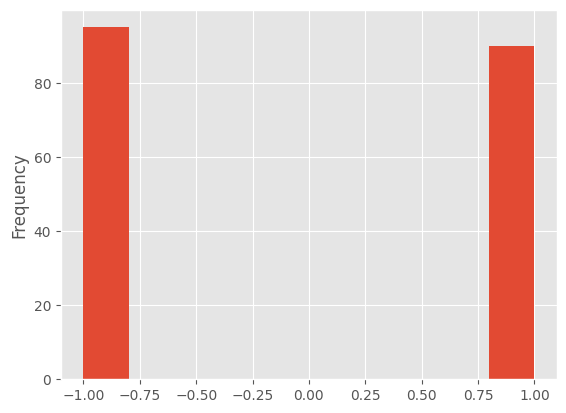

In [24]:
plt.style.use('ggplot')

daily_df['signal_daily'].plot(kind='hist')

plt.show()

### 4. Merge with intraday data and calculate intraday indicators to form the intraday signal.
- Calculate all intraday indicators and intraday signal.

In [25]:
final_df = intraday_5min_df.reset_index()\
                            .merge(daily_df[['signal_daily']].reset_index(),
                                   left_on='date',
                                   right_on='Date')\
                            .drop(['date','Date'], axis=1)\
                            .set_index('datetime')

final_df['rsi'] = pandas_ta.rsi(close=final_df['close'],
                                length=20)

final_df['lband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,0]

final_df['uband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,2]

final_df['signal_intraday'] = final_df.apply(lambda x: 1 if (x['rsi']>70)&
                                                            (x['close']>x['uband'])
                                             else (-1 if (x['rsi']<30)&
                                                         (x['close']<x['lband']) else np.nan),
                                             axis=1)

final_df['return'] = np.log(final_df['close']).diff()

final_df

open         low        high       close  volume  \
datetime                                                                      
2021-09-29 20:00:00  10379.7775  10364.5950  10398.7025  10370.9575      46   
2021-09-29 20:05:00  10370.9425  10352.4175  10380.2500  10371.1450      53   
2021-09-29 20:10:00  10372.8150  10357.8250  10388.7500  10384.3125     116   
2021-09-29 20:15:00  10385.8275  10384.0825  10457.2000  10442.5175     266   
2021-09-29 20:20:00  10442.5225  10426.2375  10448.0000  10440.9950      65   
...                         ...         ...         ...         ...     ...   
2023-09-18 23:35:00   6708.0025   6705.5175   6712.0000   6708.8675      11   
2023-09-18 23:40:00   6708.8650   6707.1800   6714.2500   6709.3350      22   
2023-09-18 23:45:00   6709.9250   6704.3600   6713.5000   6708.2750      25   
2023-09-18 23:50:00   6708.2750   6705.7700   6712.7500   6705.8050      11   
2023-09-18 23:55:00   6705.8025   6705.3875   6712.0000   6706.8875       6   

                     signal_daily        rsi        lband        uband  \
datetime                                                                 
2021-09-29 20:00:00           NaN        NaN          NaN          NaN   
2021-09-29 20:05:00           NaN        NaN          NaN          NaN   
2021-09-29 20:10:00           NaN        NaN          NaN          NaN   
2021-09-29 20:15:00           NaN        NaN          NaN          NaN   
2021-09-29 20:20:00           NaN        NaN          NaN          NaN   
...                           ...        ...          ...          ...   
2023-09-18 23:35:00           NaN  62.861699  6677.365065  6715.855435   
2023-09-18 23:40:00           NaN  63.165869  6679.544207  6716.559793   
2023-09-18 23:45:00           NaN  61.954798  6682.379916  6716.534084   
2023-09-18 23:50:00           NaN  59.172065  6685.549735  6715.801265   
2023-09-18 23:55:00           NaN  60.000874  6687.480314  6715.772186   

                     signal_intraday    return  
datetime                                        
2021-09-29 20:00:00              NaN       NaN  
2021-09-29 20:05:00              NaN  0.000018  
2021-09-29 20:10:00              NaN  0.001269  
2021-09-29 20:15:00              NaN  0.005589  
2021-09-29 20:20:00              NaN -0.000146  
...                              ...       ...  
2023-09-18 23:35:00              NaN  0.000128  
2023-09-18 23:40:00              NaN  0.000070  
2023-09-18 23:45:00              NaN -0.000158  
2023-09-18 23:50:00              NaN -0.000368  
2023-09-18 23:55:00              NaN  0.000161  

[177456 rows x 11 columns]

### 5. Generate the position entry and hold until the end of the day.

In [26]:
final_df['return_sign'] = final_df.apply(lambda x: -1 if (x['signal_daily']==1)&(x['signal_intraday']==1)
                                        else (1 if (x['signal_daily']==-1)&(x['signal_intraday']==-1) else np.nan),
                                        axis=1)

final_df['return_sign'] = final_df.groupby(pd.Grouper(freq='D'))['return_sign']\
                                  .transform(lambda x: x.ffill())

final_df['forward_return'] = final_df['return'].shift(-1)

final_df['strategy_return'] = final_df['forward_return']*final_df['return_sign']

daily_return_df = final_df.groupby(pd.Grouper(freq='D'))['strategy_return'].sum()

### 6. Calculate final strategy returns.

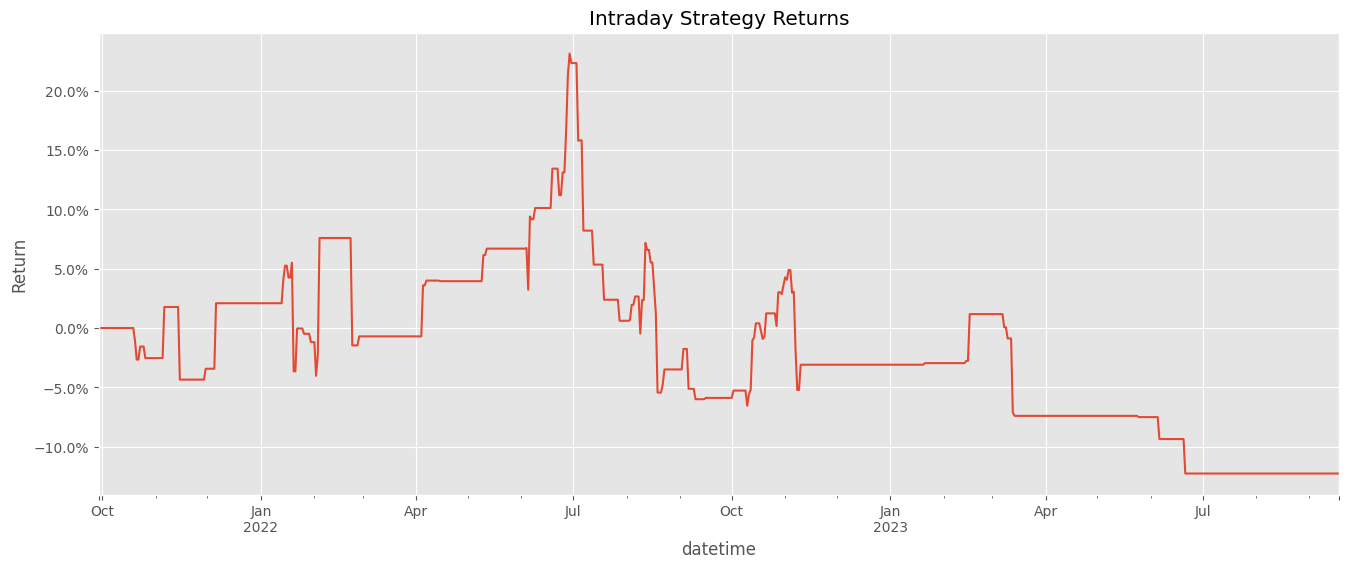

In [27]:
import matplotlib.ticker as mtick

strategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum()).sub(1)

strategy_cumulative_return.plot(figsize=(16,6))

plt.title('Intraday Strategy Returns')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()